# Evaluation of Figure 2

In this notebook, the data for Figure 2 is prepared. Note, that due to known issues in the umap-learn package, the plots are not 100% reproducable over all machines. However the overall structure will be preserved.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import scanpy as sc
import scirpy as ir
import anndata
import scipy

from matplotlib import rcParams
import matplotlib.pyplot as plt

from tqdm import tqdm

C:\Users\felix.drost\Anaconda3\envs\mvTCR_haniffa\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('../mvTCR')
import tcr_embedding.utils_training as utils
import config.constants_10x as const

In [3]:
sb.set_style("whitegrid")

In [4]:
def load_model(adata, model, weight=1):
    path_model = f'saved_models/journal_2/haniffa/full/haniffa_tcr_{model}_{weight}.pt'
    model = utils.load_model(adata, path_model)
    return model
    

In [5]:
def load_data():
    adata = utils.load_data('Haniffa')
    return adata

In [6]:
path_out = '../results/fig2_haniffa_lv.h5ad'

## Loading

In [7]:
data = load_data()

In [8]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
enc.fit(data.obs['Smoker'].to_numpy().reshape(-1, 1))
data.obsm['Smoker'] = enc.transform(data.obs['Smoker'].to_numpy().reshape(-1, 1))

## Database Query

In [9]:
data.obs = data.obs.rename(columns={'cdr3_alpha': 'IR_VJ_1_junction_aa',
                                    'cdr3_beta': 'IR_VDJ_1_junction_aa'})
data.obs['IR_VJ_2_junction_aa'] = [None] * len(data)
data.obs['IR_VDJ_2_junction_aa'] = [None] * len(data)
data.obs['has_ir'] = [True] * len(data)

In [10]:
data.uns['scirpy_version'] = '0.7'

#### IEDB Query

In [11]:
iedb = pd.read_csv('../data/IEDB.csv')
iedb = iedb[iedb['Receptor Type']=='alphabeta']
iedb = iedb[['Description', 'Antigen', 'Organism', 'MHC Allele Names',
             'Chain 1 CDR3 Calculated', 'Chain 2 CDR3 Calculated']]
iedb = iedb[~iedb['Chain 2 CDR3 Calculated'].isna() | ~iedb['Chain 1 CDR3 Calculated'].isna()]
#iedb = iedb[iedb['Organism']=='SARS-CoV2']
iedb = iedb.rename(columns={'Chain 1 CDR3 Calculated': 'IR_VJ_1_junction_aa', 
                            'Chain 2 CDR3 Calculated': 'IR_VDJ_1_junction_aa',
                            'Description': 'iedb_epitope',
                            'Antigen': 'iedb_gene',
                            'Organism': 'iedb_specie'
                           })
iedb = iedb[['IR_VJ_1_junction_aa', 'IR_VDJ_1_junction_aa', 'iedb_epitope', 'iedb_gene', 'iedb_specie']]
iedb['IR_VDJ_1_junction_aa'] = 'C' + iedb['IR_VDJ_1_junction_aa'] + 'F'
iedb['has_ir'] = True
iedb = iedb.drop_duplicates().reset_index(drop=True)
for col in ['IR_VJ_2_junction_aa', 'IR_VDJ_2_junction_aa']:
    iedb[col] = None
    
iedb = sc.AnnData(obs=iedb)
iedb.uns['DB'] = {'name': 'IEDB'}
iedb

AnnData object with n_obs × n_vars = 122523 × 0
    obs: 'IR_VJ_1_junction_aa', 'IR_VDJ_1_junction_aa', 'iedb_epitope', 'iedb_gene', 'iedb_specie', 'has_ir', 'IR_VJ_2_junction_aa', 'IR_VDJ_2_junction_aa'
    uns: 'DB'

In [12]:
ir.pp.ir_dist(data, reference=iedb, metric='levenshtein', sequence='aa', cutoff=1)
ir.tl.ir_query(data, iedb, metric='levenshtein', sequence='aa', receptor_arms='VDJ', dual_ir='primary_only')
ir.tl.ir_query_annotate(data, iedb, metric='levenshtein', sequence='aa', strategy='json',
                        include_ref_cols=['iedb_specie', 'iedb_gene', 'iedb_epitope'])
#data.obs['iedb_specie'].value_counts()

100%|████████████████████████████████████████████████████████████████████████| 115536/115536 [00:25<00:00, 4561.65it/s]


#### Save Annotated Data

In [13]:
for col in ['IR_VJ_2_junction_aa', 'IR_VDJ_2_junction_aa', 'iedb_specie']:
    data.obs[col] = data.obs[col].astype(str)
sc.write(adata=data, filename=path_out)

## Latent and UMAPs

In [14]:
data = sc.read(filename=path_out)
models = {model_name: load_model(data, model_name) for model_name in ['moe', 'rna']}

In [15]:
moe_model = models['moe']
latent_moe = moe_model.get_latent(data, metadata=[], return_mean=True)
sc.pp.neighbors(latent_moe, use_rep='X')
sc.tl.umap(latent_moe)
data.obsm['X_umap_moe'] = latent_moe.obsm['X_umap']

### Initial Visualisations

In [16]:
metadata = [
       'full_clustering',
       'Collection_Day', 'Sex',
       'Age_interval', 'Swab_result', 'Status', 'Smoker',
       'Status_on_day_collection', 'Status_on_day_collection_summary',
       'Days_from_onset', 'Site', 'Worst_Clinical_Status',
       'Outcome', 'patient_id', ]

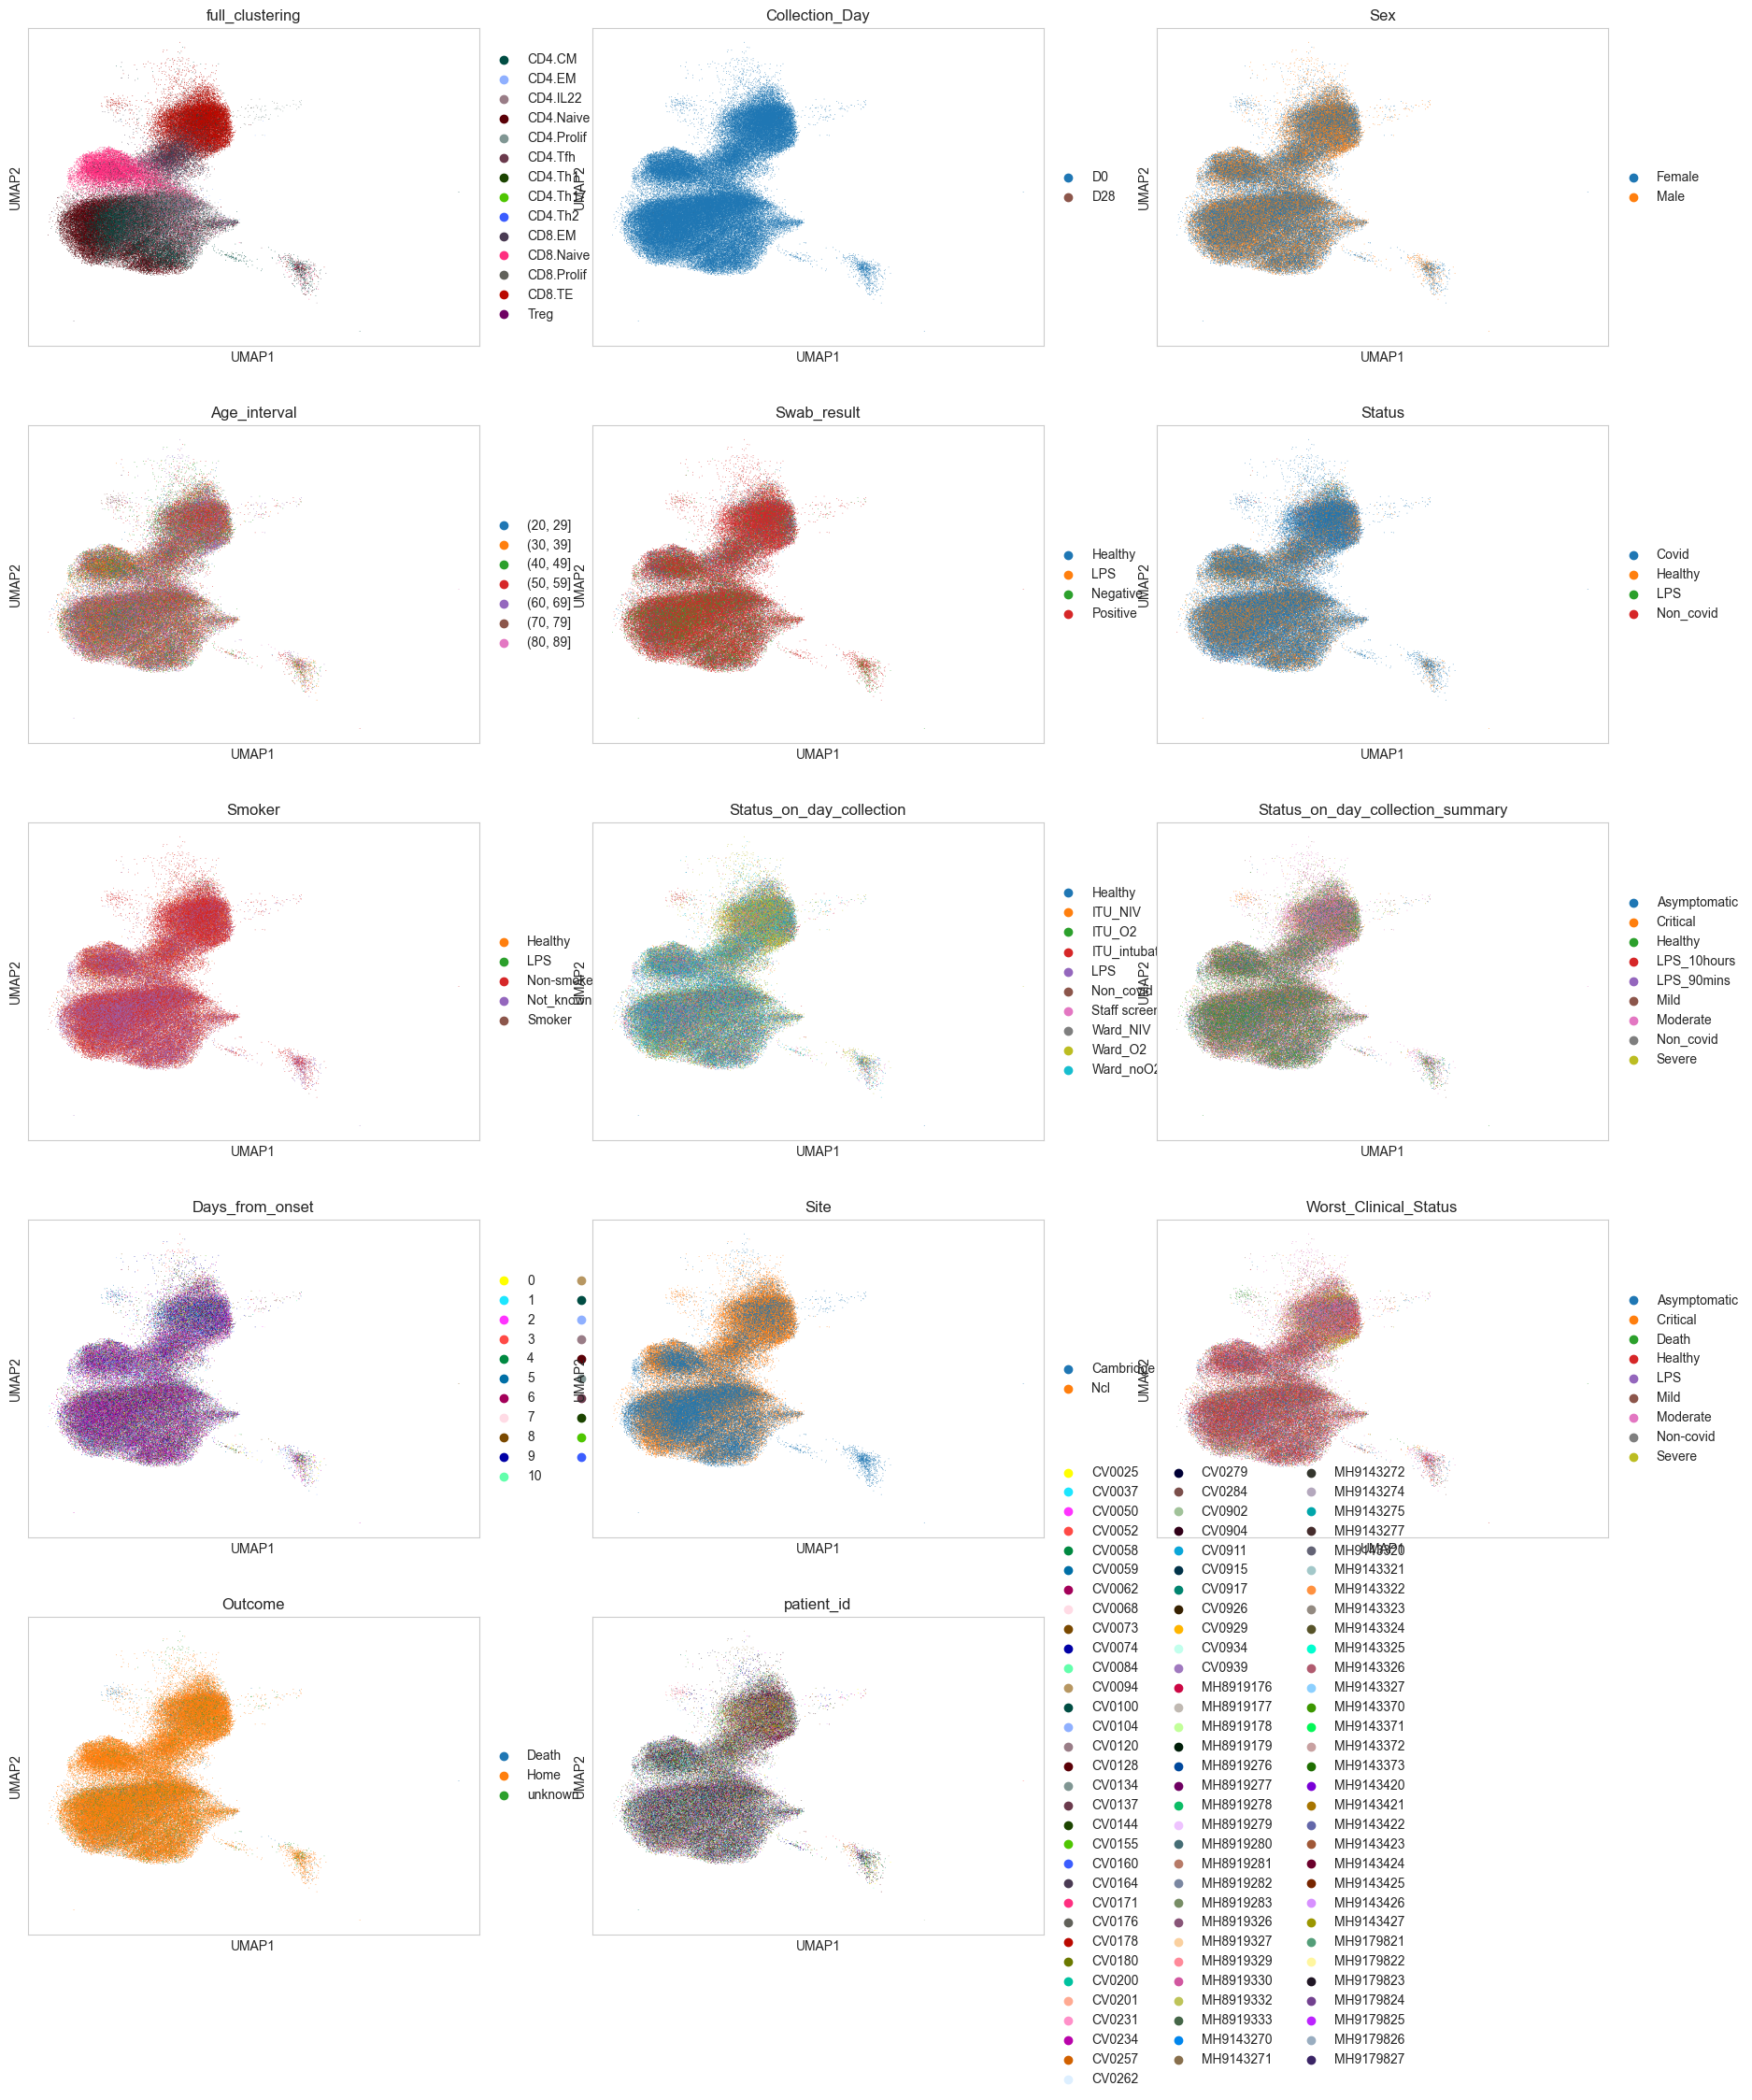

In [17]:
sc.pl.umap(data, color=metadata, ncols=3)

### Calculate latent spaces

In [18]:
moe_model = models['moe']
latent_moe = moe_model.get_latent(data, metadata=metadata, return_mean=True)
sc.pp.neighbors(latent_moe, use_rep='X')
sc.tl.umap(latent_moe)
data.obsm['X_umap_moe'] = latent_moe.obsm['X_umap']

In [19]:
rna_model = models['rna']
latent_rna = rna_model.get_latent(data, metadata=metadata)
sc.pp.neighbors(latent_rna, use_rep='X')
sc.tl.umap(latent_rna)
data.obsm['X_umap_rna'] = latent_rna.obsm['X_umap']

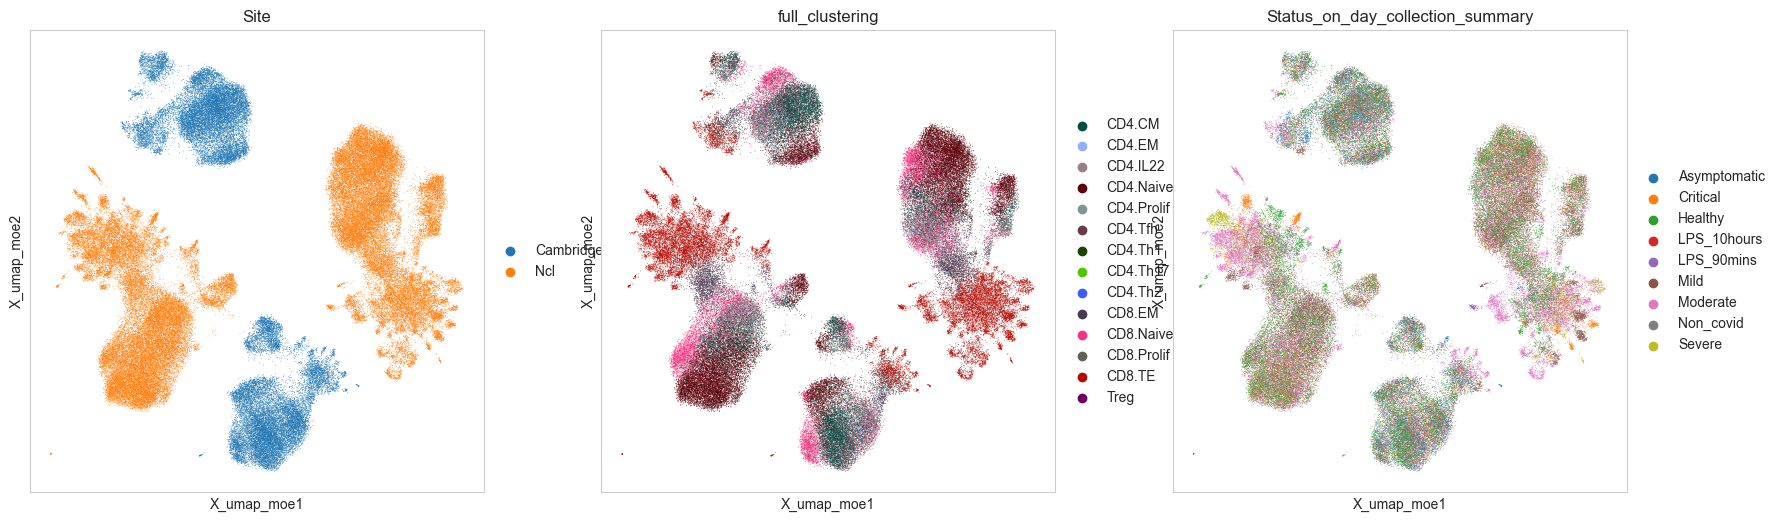

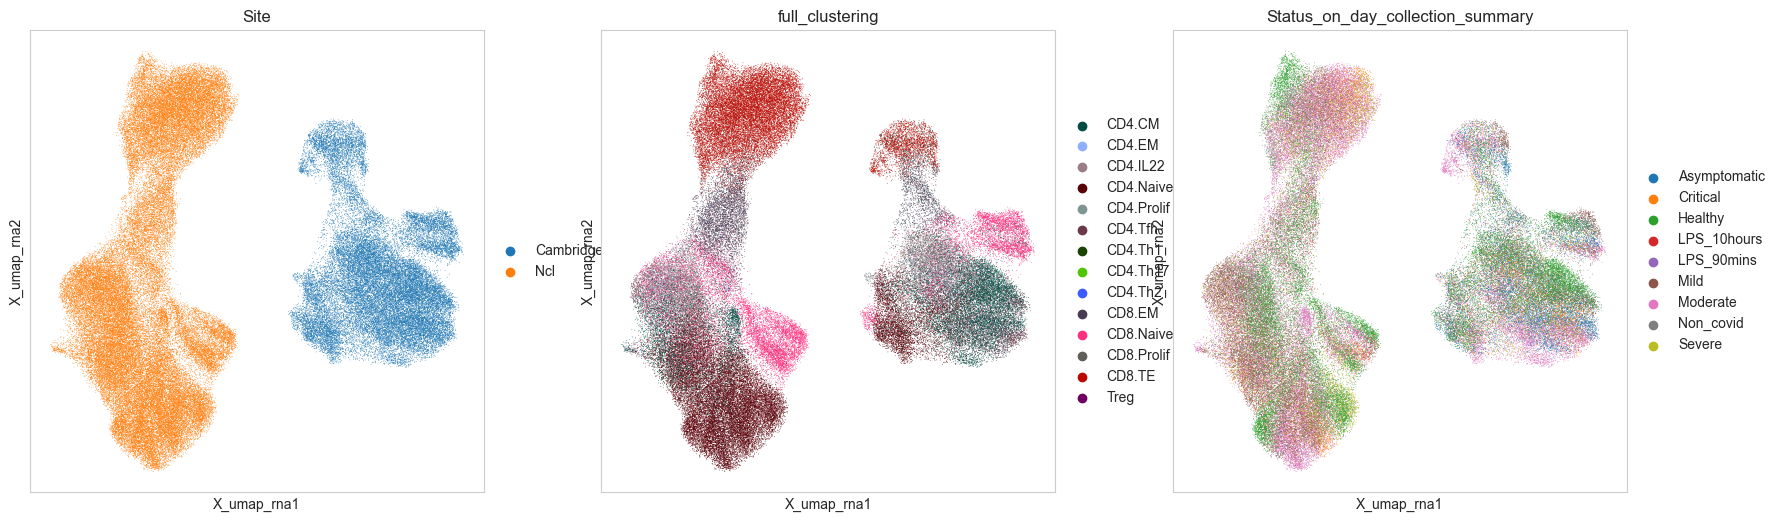

In [20]:
rcParams['figure.figsize'] = (6, 6)
sc.pl.embedding(data, basis='X_umap_moe', color=['Site', 'full_clustering', 'Status_on_day_collection_summary'], ncols=3)
sc.pl.embedding(data, basis='X_umap_rna', color=['Site', 'full_clustering', 'Status_on_day_collection_summary'], ncols=3)

## Add Marker Genes / Scores

In [21]:
tcell_markers = pd.read_excel('data/41467_2019_12464_MOESM7_ESM.xlsx', skiprows=1)
tcell_markers

Treg    CD4 NV/CM  CD4/CD8 IFN Response Proliferation CD8 Cytotoxic  \
0   LRRC32  CTB-133G6.1    WDR86        IFIT3         PYCR1          CCL5   
1     RGS1      TMEM45B     IL7R        CMPK2           NPW          GZMK   
2    FOXP3          AK5   TSPAN2        IFIT2           LIF          GNLY   
3   RNF207          NOG    LRRC2       IFI44L           IL2         TRGC2   
4    CTLA4      NGFRAP1    SNAI3         GBP1       SLC29A1        FGFBP2   
..     ...          ...      ...          ...           ...           ...   
65   NTRK2         IL24    ITGB7         RTP4        SH2D4A        SETBP1   
66  FAM46C        PLCL1    ACSF2        APOL2          YRDC      COLGALT2   
67   KLHL5       LETMD1  ATXN7L1          LPP       C10orf2       KIR2DL4   
68  IZUMO4       SLC8B1    PINK1        SP110         TRAP1        FKBP1B   
69    TFEB        ITGA6    PDCD4      FAM19A2        TIMM8A        ADGRG1   

   CD8 Cytokine  
0          CCL3  
1        CCL3L3  
2        CCL4L2  
3          IFNG  
4          CCL4  
..          ...  
65        PRDM1  
66        KLRD1  
67      ST8SIA4  
68         IER3  
69         PLEK  

[70 rows x 7 columns]

In [22]:
for k, v in tcell_markers.items():
    score_name = k.lower() + "_score"
    data.obs[score_name] = np.mean(
        (
            data[:, [x for x in v if x in data.var_names]].X - 
            data[:, [x for x in v if x in data.var_names]].X.mean(axis=0)
        ) / data[:, [x for x in v if x in data.var_names]].X.todense().std(axis=0),
        axis=1)

In [23]:
expanded_clonotypes = data.obs['clonotype'].value_counts()
expanded_clonotypes = expanded_clonotypes[expanded_clonotypes>=50].index

data.obs['large_clonotype'] = [el if el in expanded_clonotypes
                              else '-99' 
                              for el in data.obs['clonotype']]

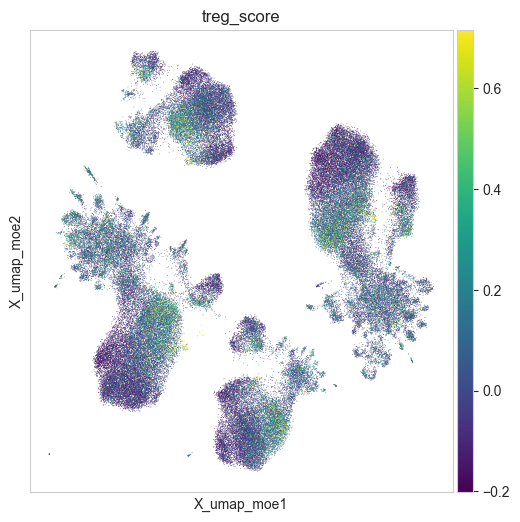

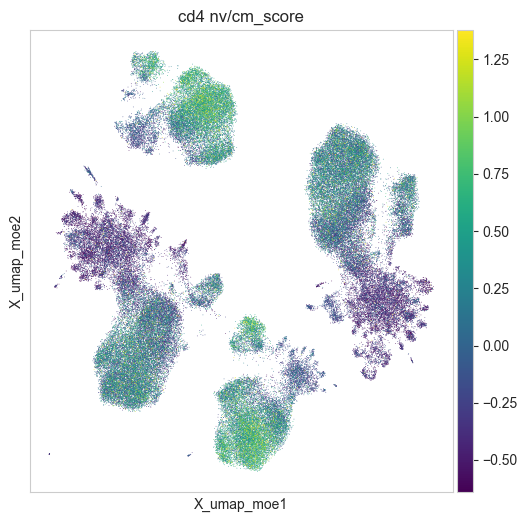

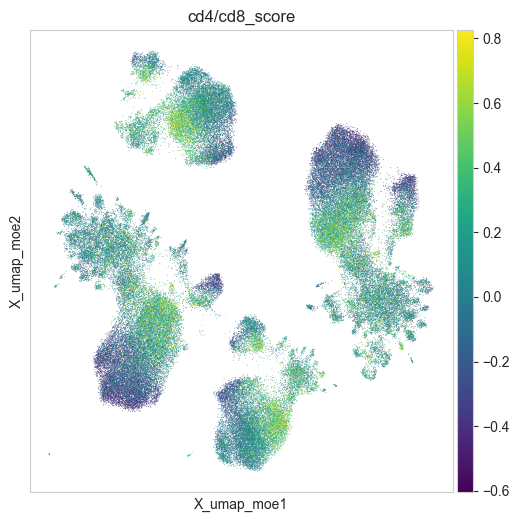

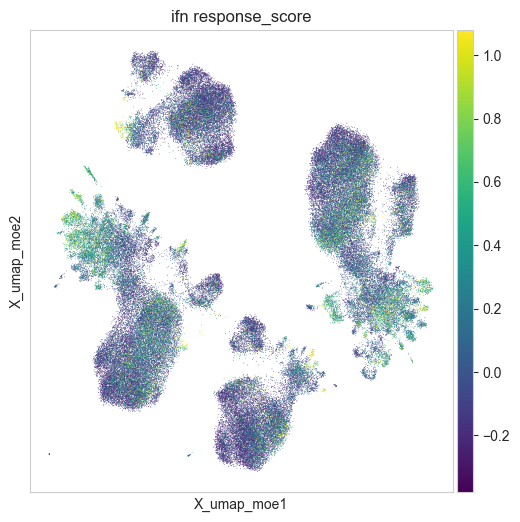

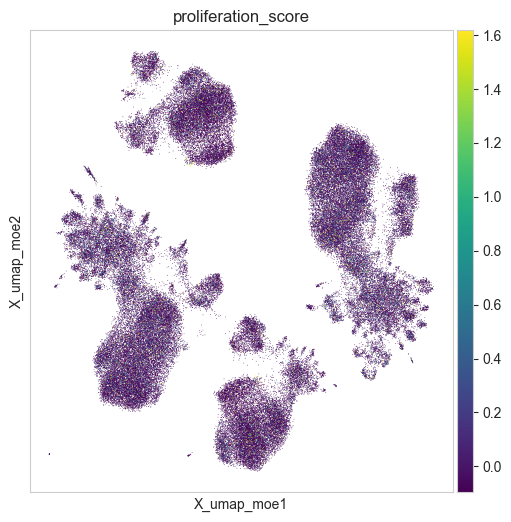

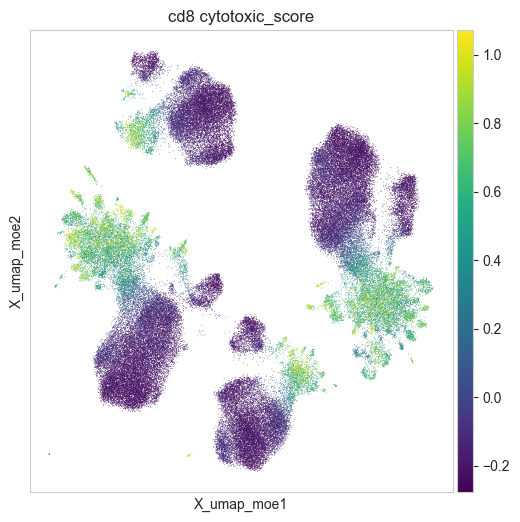

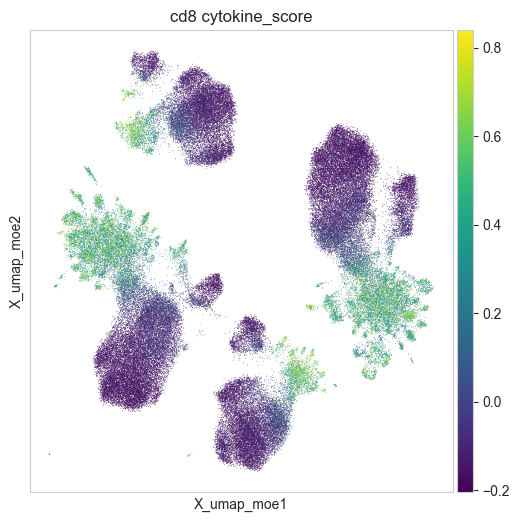

In [24]:
scores = [k.lower() + "_score" for k in tcell_markers]

for score in scores:
    lower, upper = np.percentile(data.obs[score], [1, 99])
    sc.pl.embedding(data, basis='X_umap_moe', color=score, vmin=lower, vmax=upper, cmap='viridis')

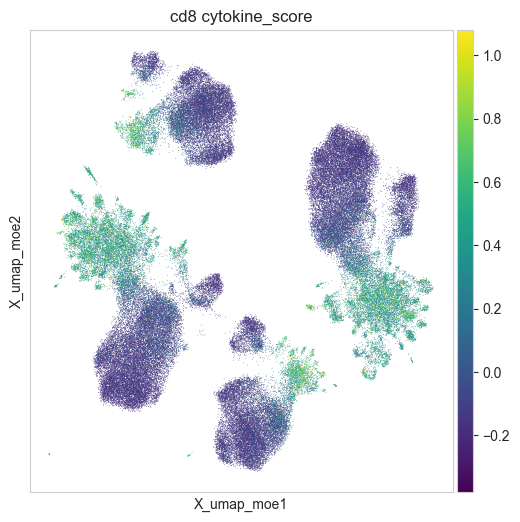

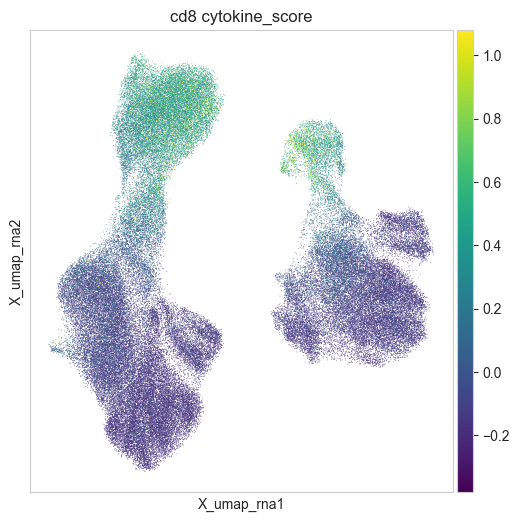

In [25]:
lower, upper = np.percentile(data.obs['ifn response_score'], [1, 99])
sc.pl.embedding(data, basis='X_umap_moe', color=score, vmin=lower, vmax=upper, cmap='viridis')
sc.pl.embedding(data, basis='X_umap_rna', color=score, vmin=lower, vmax=upper, cmap='viridis')

In [26]:
data.obs['large_clonotype'] = data.obs['large_clonotype'].astype(str)
data.obs['large_clonotype'] = data.obs['large_clonotype'].replace('-99', np.nan) 

## CD8TE clustering

In [27]:
latent_moe_cd8ef = latent_moe[latent_moe.obs['full_clustering']=='CD8.TE']
sc.pp.neighbors(latent_moe_cd8ef)
sc.tl.leiden(latent_moe_cd8ef, resolution=1)
data.obs['leiden_moe_cd8te'] = latent_moe_cd8ef.obs['leiden']
data_cd8te = data[data.obs['full_clustering']=='CD8.TE']

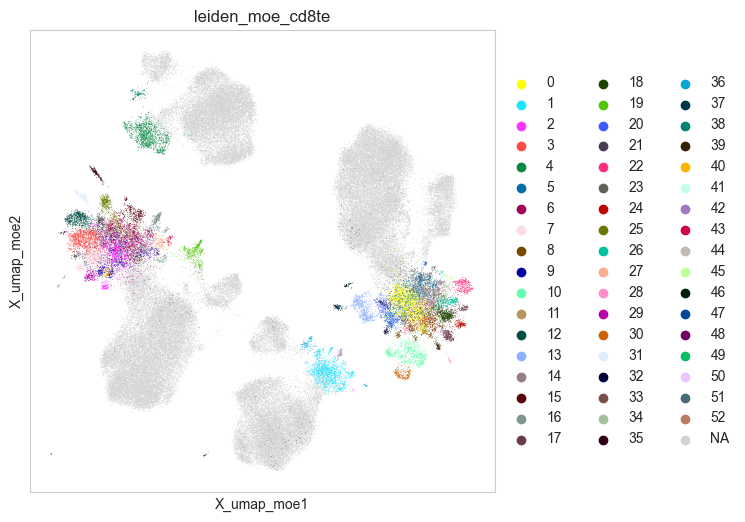

In [28]:
sc.pl.embedding(data, basis='X_umap_moe', color=['leiden_moe_cd8te'])

In [29]:
latent_rna_cd8ef = latent_rna[latent_rna.obs['full_clustering']=='CD8.TE']
sc.pp.neighbors(latent_rna_cd8ef)
sc.tl.leiden(latent_rna_cd8ef, resolution=3.5)  #  3.5 yields a similar number of clusters than the MOE model
data.obs['leiden_rna_cd8te'] = latent_rna_cd8ef.obs['leiden']
data_cd8te = data[data.obs['full_clustering']=='CD8.TE']

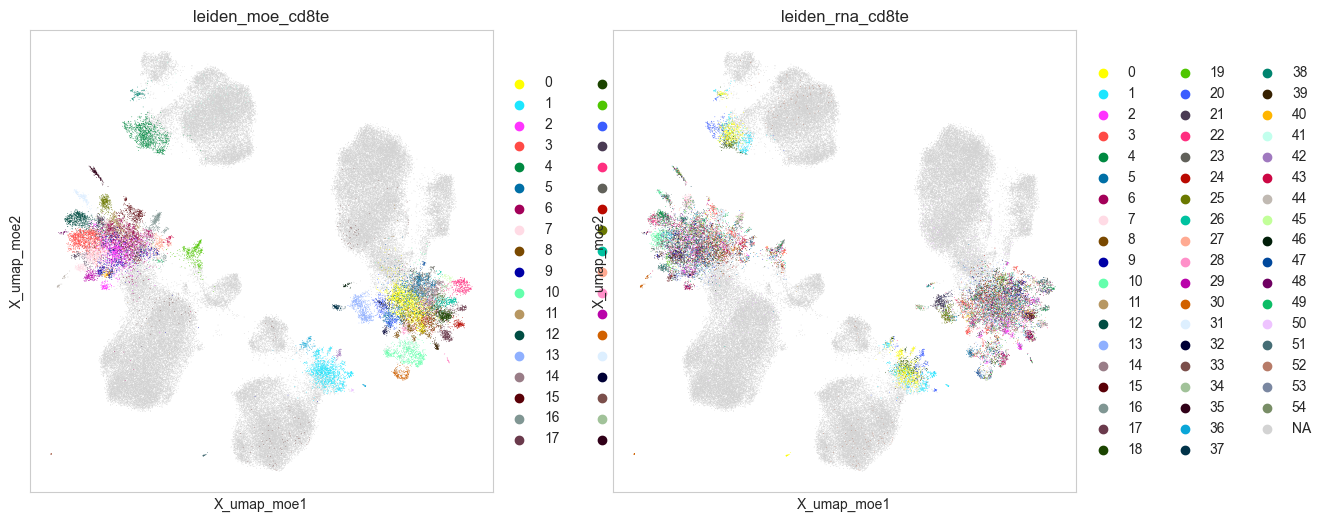

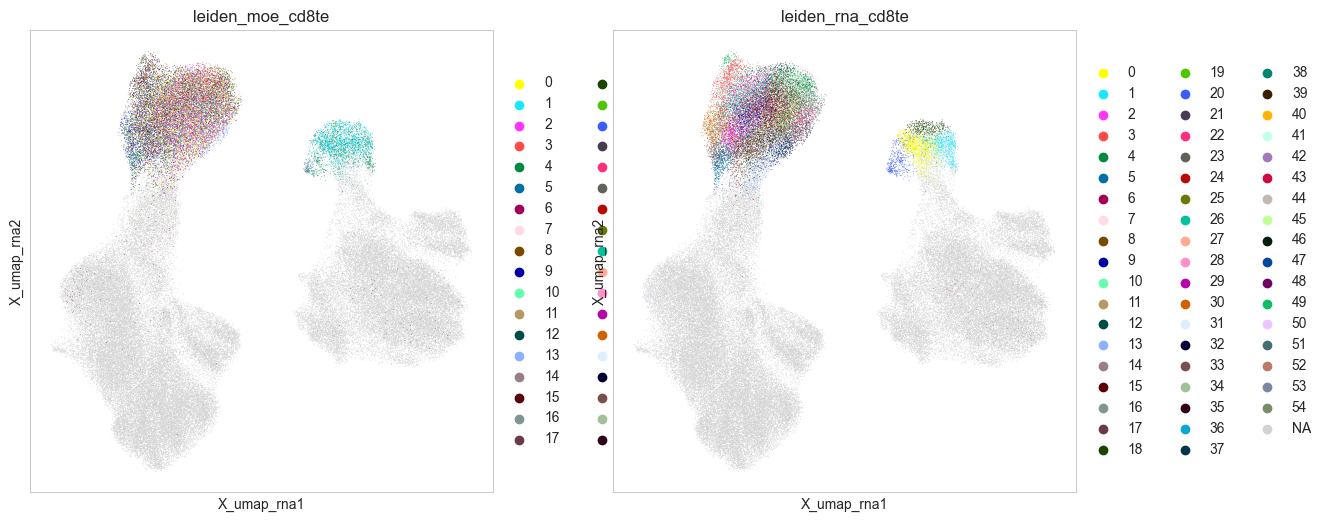

In [30]:
rcParams['figure.figsize'] = (6, 6)
sc.pl.embedding(data, basis='X_umap_moe', color=['leiden_moe_cd8te', 'leiden_rna_cd8te'])
sc.pl.embedding(data, basis='X_umap_rna', color=['leiden_moe_cd8te', 'leiden_rna_cd8te'])

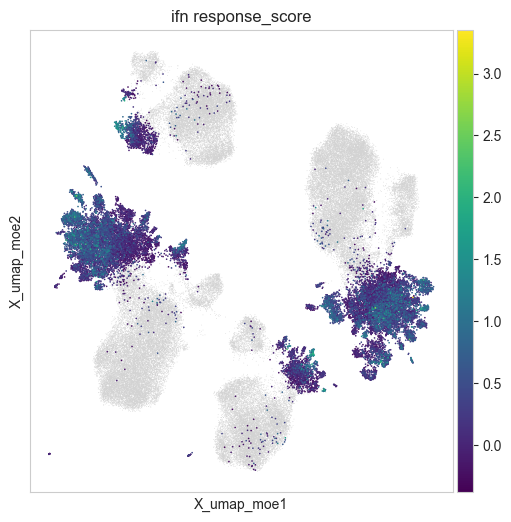

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.embedding(data, basis='X_umap_moe', show=False, ax=ax)
sc.pl.embedding(data_cd8te, basis='X_umap_moe', color='ifn response_score', ax=ax, show=False, cmap='viridis')
plt.show()

In [32]:
def map_pvalue_sign(p):
    if p < 0.001:
        return '***'
    if p < 0.01:
        return '**'
    if p < 0.05:
        return '*'
    return ''

In [33]:
for modality in ['moe', 'rna']:
    ps_by_cluster = {}
    ts_by_cluster = {}
    score = 'ifn response_score'
    for cluster in sorted(data_cd8te.obs[f'leiden_{modality}_cd8te'].unique().astype(int)):
        cluster = str(cluster)
        ifn_cluster = data_cd8te[data_cd8te.obs[f'leiden_{modality}_cd8te']==cluster].obs[score]
        ifn_rest = data_cd8te[data_cd8te.obs[f'leiden_{modality}_cd8te']!=cluster].obs[score]

        p_value = scipy.stats.ttest_ind(a=ifn_cluster, b=ifn_rest, equal_var=False, alternative='greater')

        ps_by_cluster[cluster] = p_value[1]
        ts_by_cluster[cluster] = p_value[0]
        #raise ValueError

    supplement_s2 = pd.DataFrame(data={'t-statistic': ts_by_cluster.values(),
                                         'p_value': ps_by_cluster.values()}, 
                                 index=ps_by_cluster.keys(),)
    supplement_s2.index.name = 'cluster'
    supplement_s2.to_excel('../results/supplement/s2_statistics_sars_cov_clusters.xlsx', sheet_name=f'ifn-response_{modality}')

    ps_by_cluster = pd.DataFrame(data={'p_value': ps_by_cluster.values()}, 
                                 index=ps_by_cluster.keys(),)
    ps_by_cluster.index.name = 'cluster'
    ps_by_cluster['sign'] = ps_by_cluster['p_value'].map(map_pvalue_sign)
    ps_by_cluster['cluster+sign'] = ps_by_cluster.index + '\n' + ps_by_cluster['sign']
    
    print(f'{modality}')
    print(ps_by_cluster['sign'].value_counts())
    data.uns[f'{modality}_ifnResponse_cluster'] = ps_by_cluster.copy()
    
    react_leiden = ps_by_cluster[ps_by_cluster['sign']=='***'].index
    data.uns[f'{modality}_reactiveClusters'] = list(react_leiden)

moe
       34
***    13
**      3
*       3
Name: sign, dtype: int64
rna
       36
***    17
**      1
*       1
Name: sign, dtype: int64


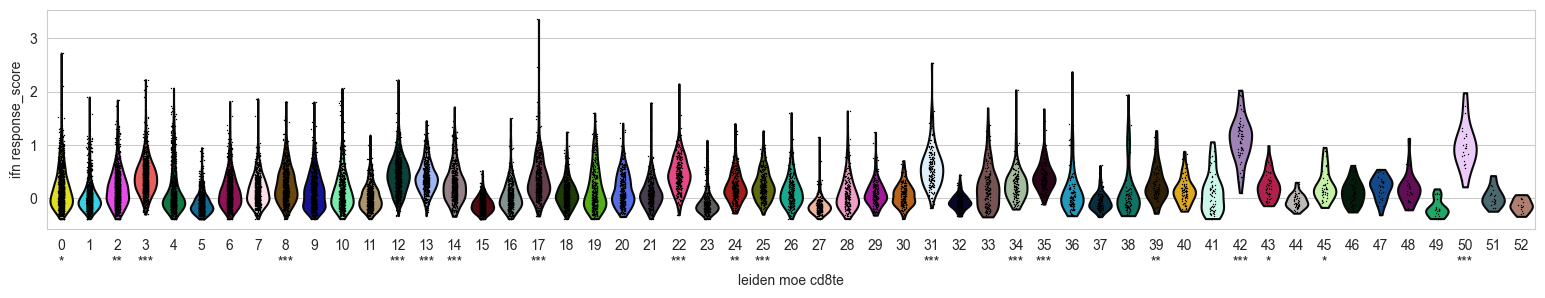

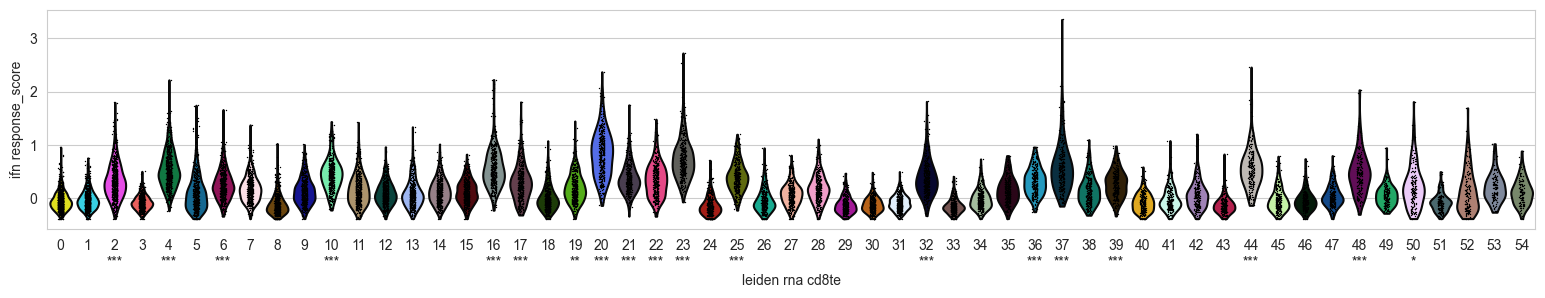

In [34]:
rcParams['figure.figsize'] = (15, 3)
for modality in ['moe', 'rna']:
    plot = sc.pl.violin(data_cd8te, keys=score, groupby=f'leiden_{modality}_cd8te', figsize=(20, 3), show=False)
    plot.set_xticklabels(data.uns[f'{modality}_ifnResponse_cluster']['cluster+sign'].values)
    plt.show()
rcParams['figure.figsize'] = (6, 6)

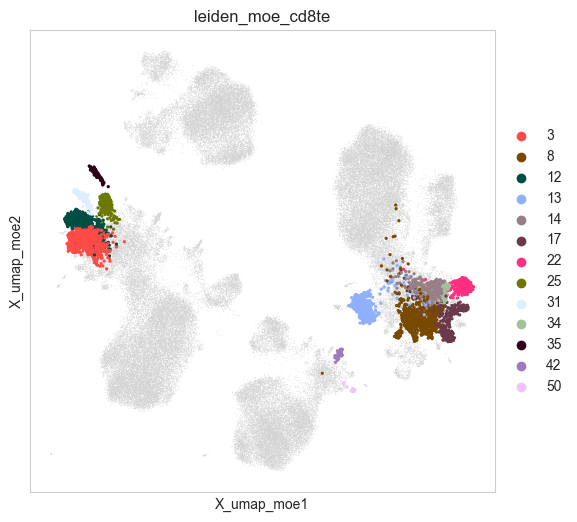

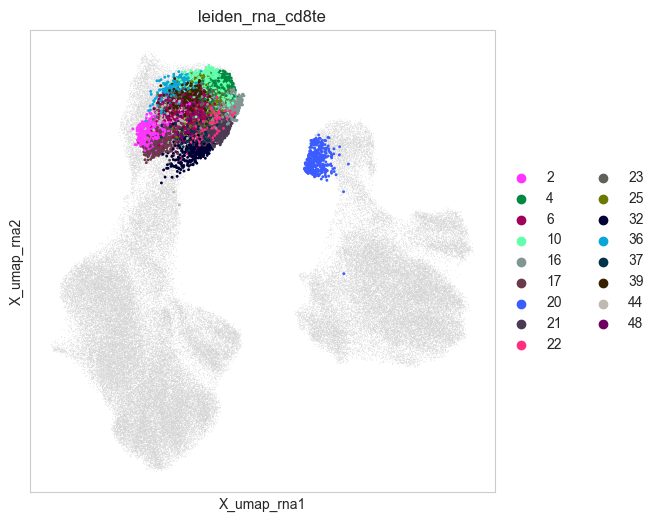

In [35]:
for modality in ['moe', 'rna']:
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    sc.pl.embedding(data, basis=f'X_umap_{modality}', show=False, ax=ax)
    sc.pl.embedding(data[data.obs[f'leiden_{modality}_cd8te'].isin(data.uns[f'{modality}_reactiveClusters'])], 
                    basis=f'X_umap_{modality}', 
                    color=f'leiden_{modality}_cd8te', ax=ax, show=False, cmap='viridis')
    plt.show()

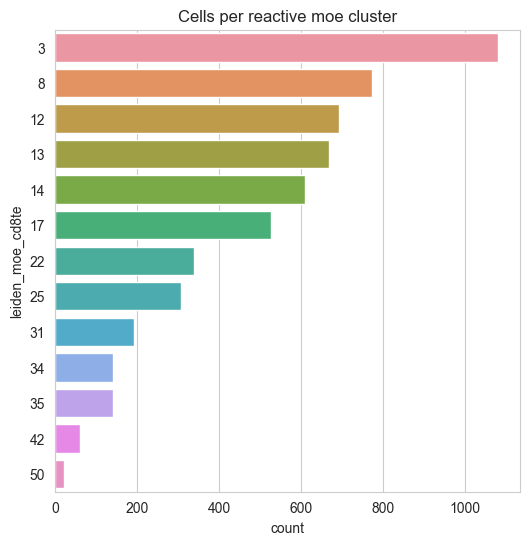

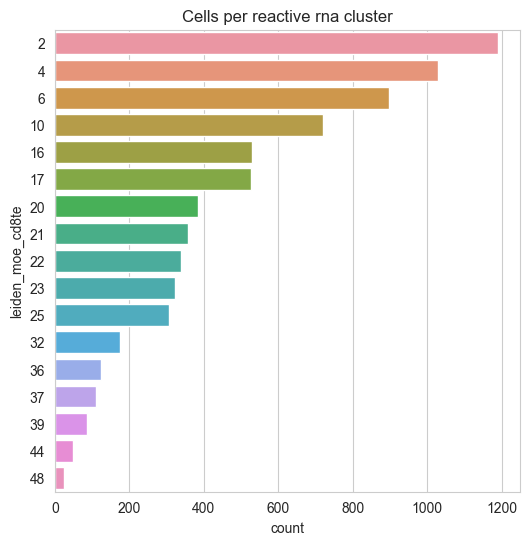

In [36]:
for modality in ['moe', 'rna']:
    plot = sb.countplot(data=data_cd8te[data_cd8te.obs['leiden_moe_cd8te'
                                                      ].isin(data.uns[f'{modality}_reactiveClusters'])].obs, 
                        y='leiden_moe_cd8te')
    plot.set_title(f'Cells per reactive {modality} cluster')
    plt.show()

In [37]:
data_cd8te.obs['iedb_specie'] = data_cd8te.obs['iedb_specie'].astype(str)
data_cd8te.obs['iedb_specie'].loc[data_cd8te.obs['iedb_specie'].isna()] = 'No Annotation'
data_cd8te.obs['iedb_specie'].loc[data_cd8te.obs['iedb_specie']=='nan'] = 'No Annotation'
data_cd8te.obs['iedb_specie']

AAACCTGAGAAACCTA-MH9179824       No Annotation
AAACCTGGTTGAGTTC-MH9179824       No Annotation
AAAGTAGTCCATGAAC-MH9179824       No Annotation
AACCATGGTGTTTGGT-MH9179824    {"SARS-CoV2": 2}
AACGTTGAGTACGACG-MH9179824       No Annotation
                                    ...       
BGCV13_TCGTAGAAGATCACGG-1        No Annotation
BGCV13_TCTCATAGTTCCCGAG-1     {"SARS-CoV2": 1}
BGCV13_TGCCCTAGTCAACATC-1        No Annotation
BGCV13_TGGGAAGTCCGCTGTT-1        No Annotation
BGCV13_TGGTTAGTCTACTCAT-1        No Annotation
Name: iedb_specie, Length: 21276, dtype: object

Text(0.5, 1.0, 'Unique Clonotypes per cluster')

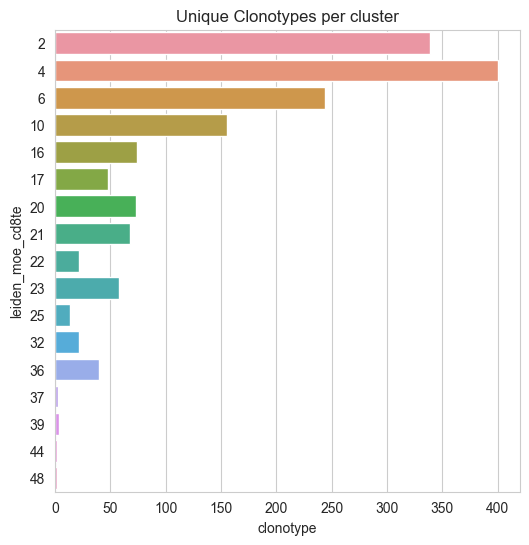

In [38]:
counts = data_cd8te[data_cd8te.obs['leiden_moe_cd8te'].isin(react_leiden.values)].obs.groupby('leiden_moe_cd8te'
                                                                                             )['clonotype']
counts = counts.nunique().reset_index()
plot = sb.barplot(data=counts, x='clonotype', y='leiden_moe_cd8te')
plot.set_title('Unique Clonotypes per cluster')

<AxesSubplot:title={'center':'Number of cells in leiden_moe_cd8te by Status'}, xlabel='leiden_moe_cd8te', ylabel='Number of cells'>

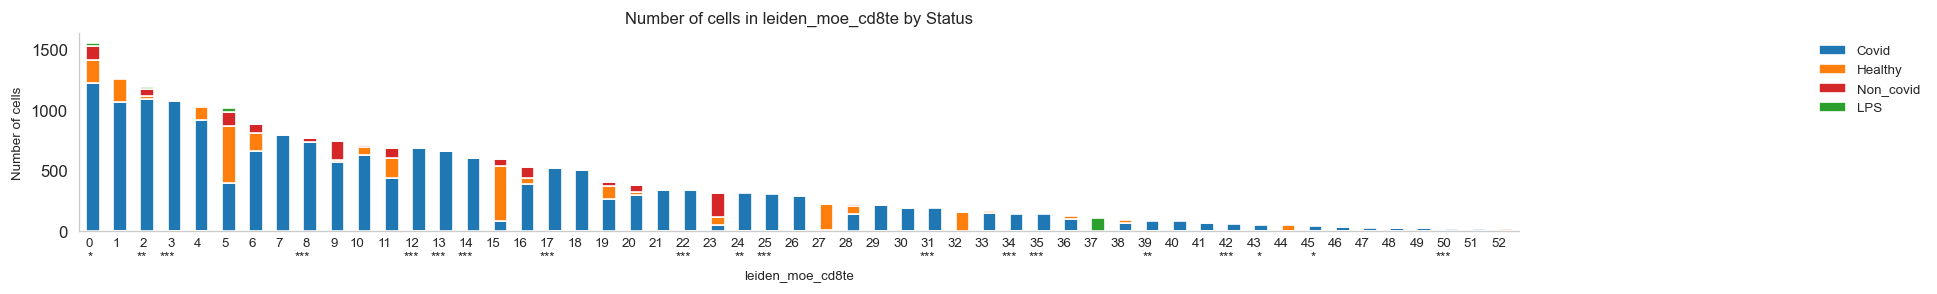

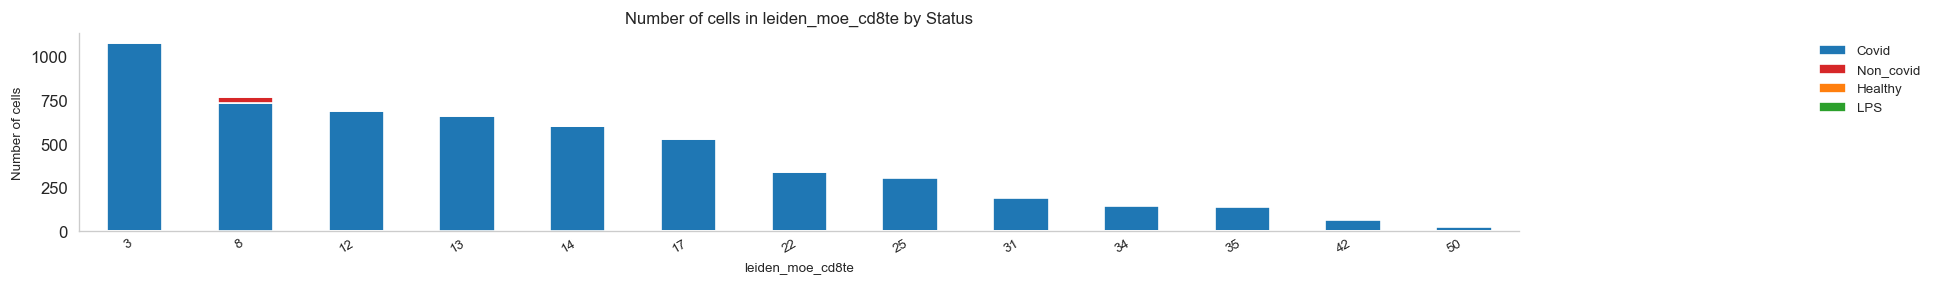

In [39]:
plot = ir.pl.group_abundance(data_cd8te, 'leiden_moe_cd8te', 'Status', figsize=(20, 3))
plot.set_xticklabels(data.uns[f'moe_ifnResponse_cluster']['cluster+sign'].values, rotation=0)

ir.pl.group_abundance(data_cd8te[data_cd8te.obs['leiden_moe_cd8te'].isin(data.uns['moe_reactiveClusters'])], 'leiden_moe_cd8te',
                      'Status', figsize=(20, 3))


<AxesSubplot:title={'center':'Number of cells in leiden_moe_cd8te by Status_on_day_collection_summary'}, xlabel='leiden_moe_cd8te', ylabel='Number of cells'>

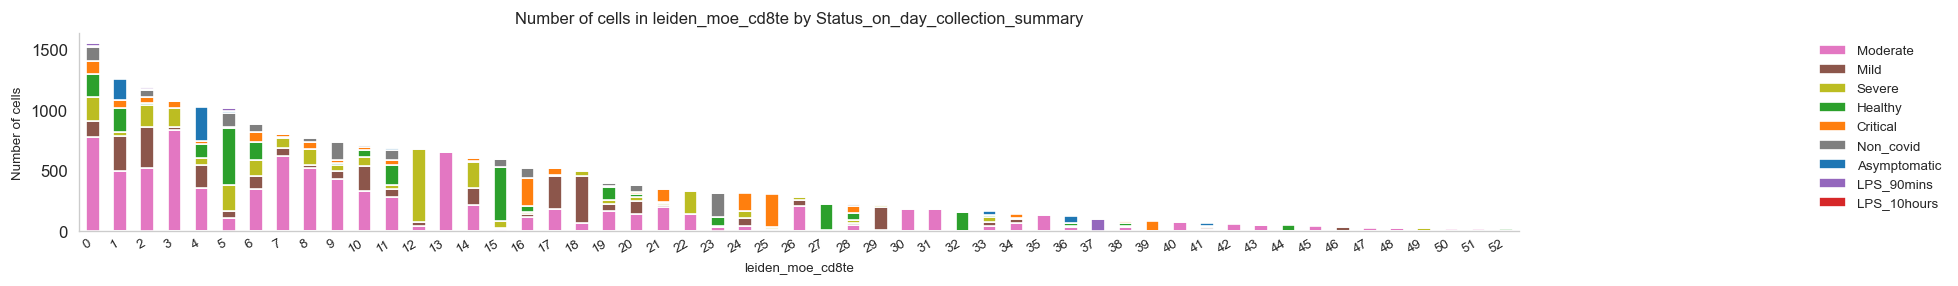

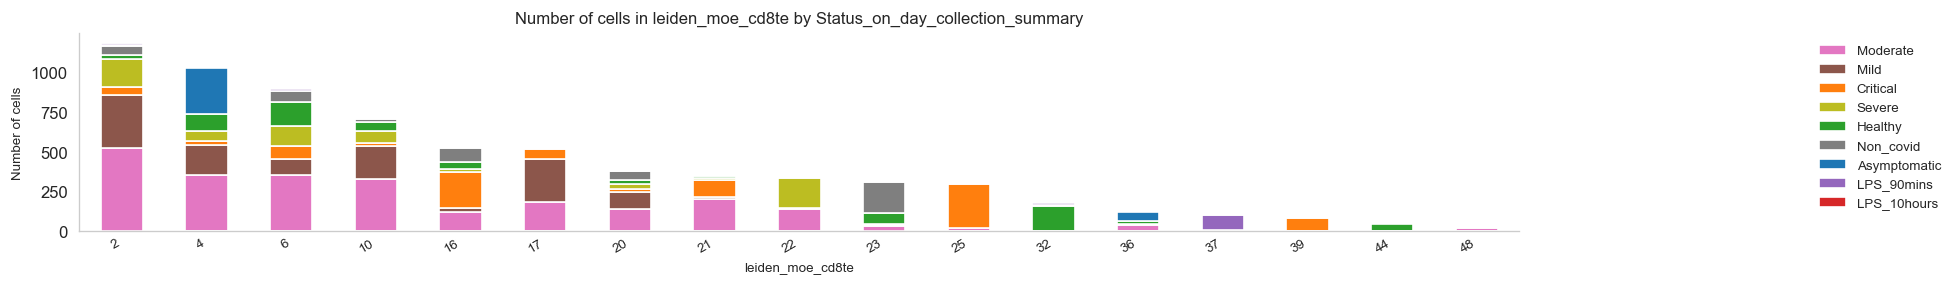

In [40]:
ir.pl.group_abundance(data_cd8te, 'leiden_moe_cd8te', 'Status_on_day_collection_summary', figsize=(20, 3))
ir.pl.group_abundance(data_cd8te[data_cd8te.obs['leiden_moe_cd8te'].isin(react_leiden)], 'leiden_moe_cd8te', 
                      'Status_on_day_collection_summary', figsize=(20, 3))


In [41]:
data_cd8te.obs['days_from_onset_grouped'] = [f'{(int(el)//3)*3}-' if el.isnumeric() else 'No Covid' for el in 
                                            data_cd8te.obs['Days_from_onset']]
data_cd8te.obs['days_from_onset_grouped'] = data_cd8te.obs['days_from_onset_grouped'].astype(str)

In [42]:
data.obs['days_from_onset_numeric'] = [float(el) if el.isnumeric() else np.nan for el in 
                                            data.obs['Days_from_onset']]
data.obs['days_from_onset_numeric'] = data.obs['days_from_onset_numeric'].astype(float)
data.obs['days_from_onset_grouped'] = [f'{(int(el)//3)*3}-{(1+int(el)//3)*3-1}' if el.isnumeric() and int(el) < 15
                                       else '>15' if el.isnumeric()
                                       else np.nan for el in 
                                            data.obs['Days_from_onset']]

In [43]:
ir.tl.clonal_expansion(data, target_col='clonotype', clip_at=len(data))
ir.tl.clonal_expansion(data, target_col='clonotype', clip_at=5, key_added='clonal_exp_clipped')
data.obs['clonal_expansion'] = data.obs['clonal_expansion'].astype(int)

## HLA Typing

In [44]:
hla_data = pd.read_csv('../data/s3_haniffa_hla.txt', sep='\t', index_col='sample_id')
for col in hla_data.columns.tolist():
    col_vals = hla_data[col]
    data.obs[col] = data.obs['patient_id'].map(col_vals)
    
for mhc in ['HLA.A', 'HLA.B', 'HLA.C']:
    mhc_name = mhc.replace('.', '-')
    data.obs[mhc] = mhc_name + data.obs[mhc].str.split('|').str[0] + '|' + mhc_name + data.obs[mhc].str.split('|').str[1]

In [45]:
import scipy

In [46]:
def majority_hla(hla_type, verbose=False):
    if verbose:
        print(hla_type)
    hla_dict = {
            'leiden': [],
            'hla_type': [],
            'hla_max': [],
            'hal_max_val': [],
            'n_leiden': [],
            'max_donor': [],
            'hla_total': [],
            'p_total': [],
            'p_donor': [],
        }
    for leiden in react_leiden:
        hlas_tmp = data[data.obs['leiden_moe_cd8te']==leiden].obs[hla_type].str.split('|', expand=True)
        unique_hlas = list(set(hlas_tmp[0].unique().tolist() + hlas_tmp[1].unique().tolist()))

        max_hla = None
        max_val = None
        for hla in unique_hlas:
            count = np.sum((hlas_tmp[0]==hla) | (hlas_tmp[1]==hla))
            if max_val is None or max_val < count:
                max_val = count
                max_hla = hla
        max_donor = data[data.obs['leiden_moe_cd8te']==leiden].obs['sample_id'].value_counts().head(1).values[0]
        total = np.sum(data.obs[hla_type].str.contains(max_hla))
        if verbose:
            print(f'  Leiden {leiden}: {max_hla} in {max_val/len(hlas_tmp):.2f} of cells' 
                  + f'(donor {max_donor/len(hlas_tmp):.2f}) '
                  + f'(total {total/len(data):.2f})')
        
        hla_dict['hla_type'].append(hla_type)
        hla_dict['leiden'].append(leiden)
        hla_dict['hla_max'].append(max_hla)
        hla_dict['hal_max_val'].append(max_val)
        hla_dict['n_leiden'].append(len(hlas_tmp))
        hla_dict['max_donor'].append(max_donor)
        hla_dict['hla_total'].append(total)
        
        p_total = scipy.stats.binom_test(x=max_val, n=len(hlas_tmp), p=total/len(data))
        p_donor = scipy.stats.binom_test(x=max_val, n=len(hlas_tmp), p=max_donor/len(hlas_tmp))
        hla_dict['p_total'].append(p_total)
        hla_dict['p_donor'].append(p_donor)
        
    hla_dict = pd.DataFrame(hla_dict) 
    return hla_dict

hla_usage = []
for t in ['HLA.A', 'HLA.B', 'HLA.C']:
    hla_usage.append(majority_hla(t, verbose=False))

hla_usage = pd.concat(hla_usage)
hla_usage = hla_usage.reset_index(drop=True)
hla_usage['hal_max_%'] = hla_usage['hal_max_val'] / hla_usage['n_leiden']
hla_usage['hal_total_%'] = hla_usage['hla_total'] / len(data)
hla_usage['p_total_sign'] = hla_usage['p_total'].map(map_pvalue_sign)
hla_usage['p_donor_sign'] = hla_usage['p_donor'].map(map_pvalue_sign)
hla_usage.head()

leiden hla_type    hla_max  hal_max_val  n_leiden  max_donor  hla_total  \
0      2    HLA.A  HLA-A0101          627      1189        255      29382   
1      4    HLA.A  HLA-A0301          368      1029        131      35173   
2      6    HLA.A  HLA-A0201          489       896         95      50933   
3     10    HLA.A  HLA-A0201          407       719        133      50933   
4     16    HLA.A  HLA-A0201          357       530        230      50933   

        p_total        p_donor  hal_max_%  hal_total_% p_total_sign  \
0  9.821285e-70  3.066844e-123   0.527334     0.283170          ***   
1  2.108476e-01   2.701617e-79   0.357629     0.338981                
2  1.050602e-03  1.516447e-230   0.545759     0.490868           **   
3  5.506613e-05  1.863985e-114   0.566064     0.490868          ***   
4  2.327616e-17   1.449838e-28   0.673585     0.490868          ***   

  p_donor_sign  
0          ***  
1          ***  
2          ***  
3          ***  
4          ***

In [47]:
hla_usage['p_donor_sign'].value_counts()

***    32
       14
*       4
**      1
Name: p_donor_sign, dtype: int64

<AxesSubplot:xlabel='leiden', ylabel='hal_max_%'>

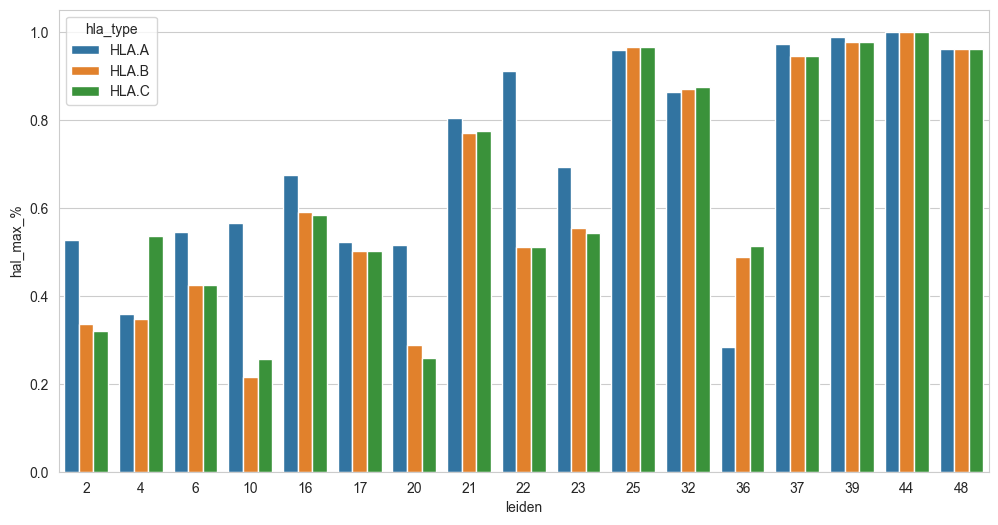

In [48]:
rcParams['figure.figsize'] = (12, 6)
sb.barplot(data=hla_usage, y='hal_max_%', x='leiden', hue='hla_type')

# Epitopes

In [49]:
aminos = 'ARNDCEQGHILKMFPSTWYV'
def valid_sequence(seq):
    valids = sum([let in aminos for let in seq])
    if valids==len(seq):
        return True
    else:
        print(seq)
        return False

In [50]:
unavailable_mhcs = ['HLA-B1526']

In [51]:
hla_by_donor = hla_data.copy()

for col in ['HLA.A', 'HLA.B', 'HLA.C']:
    hla_by_donor[f'{col}_1'] = col.replace('.', '-') + hla_by_donor[col].str.split('|').str[0]
    hla_by_donor[f'{col}_2'] = col.replace('.', '-') + hla_by_donor[col].str.split('|').str[1] 

hla_by_donor = hla_by_donor[['HLA.A_1', 'HLA.A_2', 'HLA.B_1', 'HLA.B_2', 'HLA.C_1', 'HLA.C_2']]
hla_by_donor = hla_by_donor.transpose().to_dict()
hla_by_donor = {donor: list(set([v for k, v in hla_dict.items() if v not in unavailable_mhcs])) 
                for donor, hla_dict in hla_by_donor.items()}

In [52]:
from functools import reduce

epitopes_by_donor = data[~data.obs['iedb_epitope'].isna() & ~data.obs['leiden_moe_cd8te'].isna()
                        ].obs[['patient_id', 'iedb_epitope']].copy()
#epitopes_by_donor['iedb_epitope'] = 
#epitopes_by_donor['iedb_epitope'].apply(lambda x: tuple(eval(x).keys()))

epitopes_donor_dict = {}
for donor in epitopes_by_donor['patient_id'].unique():
    all_epitopes = epitopes_by_donor[epitopes_by_donor['patient_id']==donor]
    all_epitopes = all_epitopes['iedb_epitope'].values
    all_epitopes = [list(eval(el).keys()) for el in all_epitopes]
    all_epitopes = reduce(lambda a, b: a+b, all_epitopes)
    all_epitopes = [el for el in all_epitopes if 1<len(el)<16 and valid_sequence(el)]
    all_epitopes = list(set(all_epitopes))
    epitopes_donor_dict[donor] = all_epitopes


In [53]:
import mhcflurry
predictor = mhcflurry.Class1PresentationPredictor.load()

bound_epitopes_by_donor = {}
for donor, epitope_list in epitopes_donor_dict.items():
    print(donor)
    prediction_mhc_flurry = predictor.predict(epitope_list, alleles=hla_by_donor[donor])
    prediction_mhc_flurry = prediction_mhc_flurry[prediction_mhc_flurry['affinity']<500]
    bound_epitopes_by_donor[donor] = prediction_mhc_flurry['peptide'].values   

Forcing tensorflow backend.
Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


MH9179824
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.00s/it]


Predicting affinities.


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.05it/s]


MH9143327
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.20it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 29.70it/s]


MH9143326
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.25it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.74it/s]


MH9143325
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.56it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.75it/s]


MH9143320
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 29.03it/s]


MH9143274
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 35.39it/s]


MH9179821
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.99it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.29it/s]


MH9179823
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.99it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 24.00it/s]


MH8919327
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.41it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.71it/s]


MH9143370
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 29.91it/s]


MH9143420
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.99it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.28it/s]


MH9143373
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 39.18it/s]


MH9143372
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.95it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.43it/s]


MH9143371
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.74it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 29.90it/s]


MH9143323
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.03it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.79it/s]


MH9143277
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.33it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.11it/s]


MH9143270
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.36it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.74it/s]


MH8919333
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 23.65it/s]


MH8919332
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.18it/s]


MH8919280
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.95it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.74it/s]


MH8919278
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.46it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.90it/s]


MH8919326
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.32it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.96it/s]


MH9143422
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.03it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.07it/s]


MH9143271
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.97it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.03it/s]


MH9143324
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.03it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.08it/s]


MH9143322
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.96it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 29.00it/s]


MH8919330
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.05it/s]


MH8919329
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.37it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.23it/s]


MH9179822
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.82it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 24.84it/s]


MH9143426
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.95it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.91it/s]


MH8919283
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.86it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 24.09it/s]


MH9179827
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.93it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.98it/s]


MH8919178
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.48it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.21it/s]


MH8919177
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.03it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 28.97it/s]


MH8919176
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.04it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.77it/s]


MH9143424
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.71it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.95it/s]


MH8919179
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.03it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 29.04it/s]


MH9143423
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.01it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 24.20it/s]


MH9143421
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.96it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 30.64it/s]


MH9179826
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.92it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.76it/s]


MH9143321
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.95it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.09it/s]


MH9143427
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 24.24it/s]


MH9143425
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.49it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.76it/s]


MH9143275
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.61it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.19it/s]


MH8919279
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.97it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.92it/s]


MH9179825
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.99it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.11it/s]


MH9143272
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.22it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 24.92it/s]


MH8919282
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.03it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.02it/s]


CV0144
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.77it/s]


CV0904
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.89it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.79it/s]


CV0025
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.88it/s]


CV0059
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.99it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.54it/s]


CV0052
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.36it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 26.10it/s]


CV0902
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.15it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.77it/s]


CV0068
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.61it/s]


CV0074
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.33it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.88it/s]


CV0084
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.95it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.93it/s]


CV0176
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.99it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 30.41it/s]


CV0200
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.18it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 30.49it/s]


CV0262
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.19it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 30.29it/s]


CV0164
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.79it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 28.35it/s]


CV0100
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.18it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.33it/s]


CV0120
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.56it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 30.33it/s]


CV0284
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 35.49it/s]


CV0929
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 39.71it/s]


CV0128
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.53it/s]


CV0234
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.95it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 29.91it/s]


CV0178
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 39.12it/s]


CV0201
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 35.50it/s]


CV0037
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 29.91it/s]


CV0094
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.47it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.07it/s]


CV0137
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.88it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 36.94it/s]


CV0104
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.94it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 40.78it/s]


CV0134
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.14it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.78it/s]


CV0155
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 39.12it/s]


CV0073
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.17it/s]


CV0915
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.31it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 36.85it/s]


CV0062
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.85it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.75it/s]


CV0171
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.53it/s]


CV0279
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 30.94it/s]


CV0917
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.90it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 40.13it/s]


CV0939
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.93it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 33.70it/s]


CV0231
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.47it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.93it/s]


CV0160
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.99it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.84it/s]


CV0257
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.77it/s]


CV0050
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.15it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 30.00it/s]


CV0058
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.96it/s]


CV0180
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.84it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 41.50it/s]


CV0926
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.18it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.22it/s]


CV0934
Predicting processing.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Predicting affinities.


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 29.92it/s]


In [54]:
db_epitopes = iedb.obs[[f'iedb_epitope', f'iedb_specie']].drop_duplicates().copy()
db_epitopes = db_epitopes.set_index(f'iedb_epitope')

def disease_grouping(name):
    if type(name) != str:
        return name
    if 'SARS' in name:
        return 'SARS-CoV'
    if 'Influenza' in name:
        return 'Influenza'
    if 'herpesvirus' in name:
        return 'Human Herpesvirus'
    if 'Yellow' in name:
        return 'Yellow Fever'
    return 'Others'
db_epitopes['iedb_specie'] = db_epitopes['iedb_specie'].apply(disease_grouping)

In [55]:
data.obs['Specificity_IEDB'] = np.nan
data.obs['Specificity_IEDB_epitope'] = np.nan
data.obs['Specificity_IEDB'] = data.obs['Specificity_IEDB'].astype(str)
for epitope, row in tqdm(db_epitopes.iterrows()):
    if 'phytosphingosine' in epitope:
        continue
    mask = data.obs['iedb_epitope'].str.contains(epitope) 
    mask[mask.isna()] = False
    mask_donor = data.obs['patient_id'].map(bound_epitopes_by_donor).astype(str).str.contains(epitope)
    mask = mask & mask_donor
    data.obs.loc[mask, 'Specificity_IEDB'] = row['iedb_specie']
    data.obs.loc[mask, 'Specificity_IEDB_epitope'] = epitope

data.obs['Specificity_IEDB'].value_counts()

989it [24:00:44, 87.41s/it]   


nan                  82022
SARS-CoV             13464
Human Herpesvirus     7118
Yellow Fever           699
Others                 102
Influenza               84
Name: Specificity_IEDB, dtype: int64

In [56]:
mask = data.obs['leiden_moe_cd8te'].isna()
data.obs.loc[mask, 'Specificity_IEDB'] = np.nan
data.obs['Specificity_IEDB'].value_counts()

nan                  16453
SARS-CoV              2994
Human Herpesvirus     1395
Yellow Fever           155
Others                  26
Influenza                9
Name: Specificity_IEDB, dtype: int64

In [57]:
for modality in ['moe', 'rna']:
    disease_by_leiden = {leid: {} for leid in data.uns[f'{modality}_reactiveClusters']}

    data_tmp = data[data.obs[f'leiden_{modality}_cd8te'].isin(data.uns[f'{modality}_reactiveClusters']) & 
                    (~data.obs['iedb_epitope'].isna())]
    data_tmp = data_tmp.obs[['patient_id', 'iedb_epitope', f'leiden_{modality}_cd8te', 'IR_VDJ_1_junction_aa']]
    patient_list = []
    cdr3b_list = []
    epitopes_list = []
    diseases_list = []

    for _, row in data_tmp.iterrows():
        donor = row['patient_id']
        epitopes = row['iedb_epitope']
        leid = row[f'leiden_{modality}_cd8te']

        diseases = [db_epitopes.loc[ep]['iedb_specie'] for ep in eval(epitopes) if ep in bound_epitopes_by_donor[donor]]
        diseases = list(set(diseases))

        epitopes = [ep for ep in eval(epitopes) if ep in bound_epitopes_by_donor[donor]]
        epitopes = list(set(epitopes))

        for d in diseases:
            if type(d) != str:
                continue
            if d not in disease_by_leiden[leid]:
                disease_by_leiden[leid][d] = 0
            disease_by_leiden[leid][d] += 1

        patient_list.append(donor)
        cdr3b_list.append(row['IR_VDJ_1_junction_aa'])
        epitopes_list.append(','.join(epitopes))

        diseases = [el for el in diseases if type(el)==str]
        diseases_list.append(','.join(diseases))

    disease_by_leiden = pd.DataFrame(disease_by_leiden)
    disease_by_leiden = disease_by_leiden.transpose()

    data.uns[f'{modality}_disease_by_leiden'] = disease_by_leiden.copy()

    s4_matches = pd.DataFrame(data={
        'Donor': patient_list,
        'CDR3beta': cdr3b_list,
        'Epitopes': epitopes_list,
        'Diseases': diseases_list
    })

    s4_matches = s4_matches.drop_duplicates()
    s4_matches = s4_matches[~(s4_matches['Diseases']=='')]
    s4_matches = s4_matches.reset_index(drop=True)
    if modality == 'moe':
        s4_matches.to_csv('../results/supplement/s4_database_matches.csv')
        matches_tmp = s4_matches.copy()
        print(len(data_tmp))      
        print(disease_by_leiden.sum().sum())

1839
1342.0


In [58]:
def count_plots_disease(disease_counts, modality):
    plot = disease_counts.plot(kind='bar', stacked=True)
    plot.legend(bbox_to_anchor =(0.65, 1.25))
    plt.show()
    disease_counts_norm = disease_counts.copy()
    disease_counts_norm = disease_counts_norm.div(disease_counts_norm.sum(axis=1), axis=0)
    plot = disease_counts_norm.plot(kind='bar', stacked=True)
    plot.legend(bbox_to_anchor =(0.65, 1.))
    disease_counts_ct = disease_counts.copy()
    num_cells = data[data.obs[f'leiden_{modality}_cd8te'].isin(data.uns[f'{modality}_reactiveClusters'])
                                      ].obs[f'leiden_{modality}_cd8te'].value_counts().values
    disease_counts_ct = disease_counts_ct.div(num_cells, axis=0)
    plot = disease_counts_ct.plot(kind='bar', stacked=True)
    plot.legend(bbox_to_anchor =(0.65, 1.))
    return disease_counts_norm, disease_counts_ct


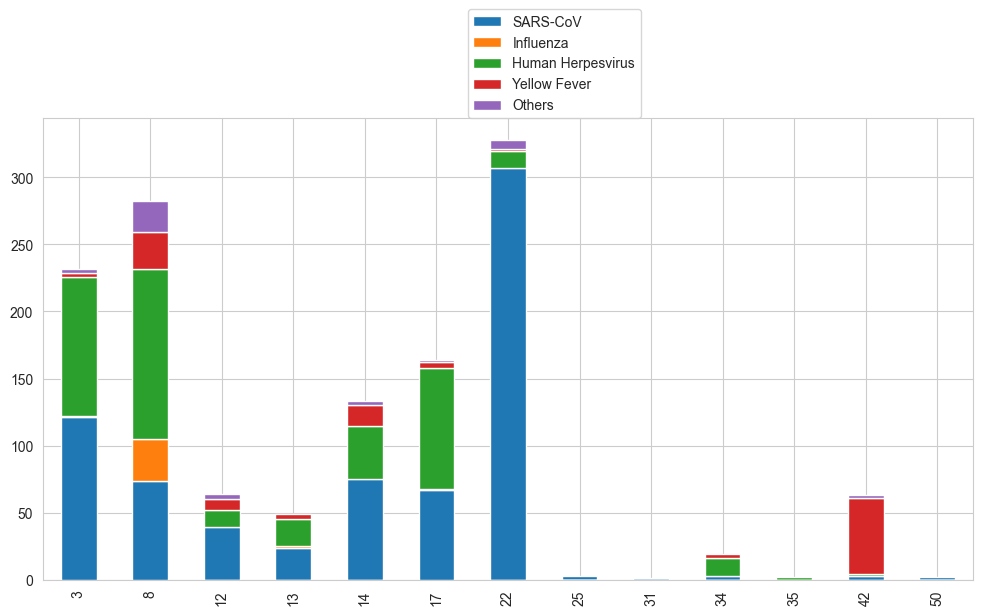

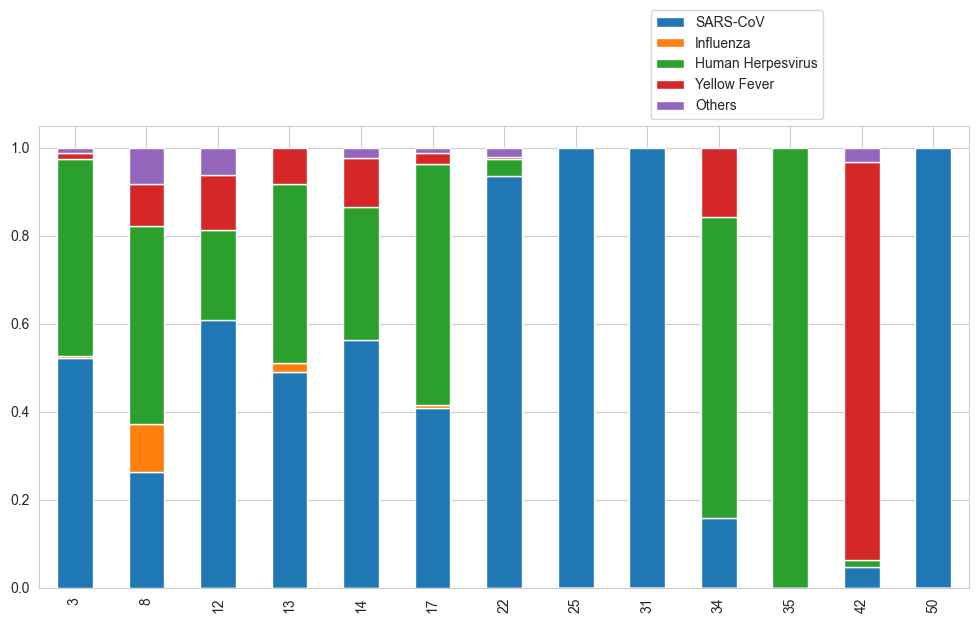

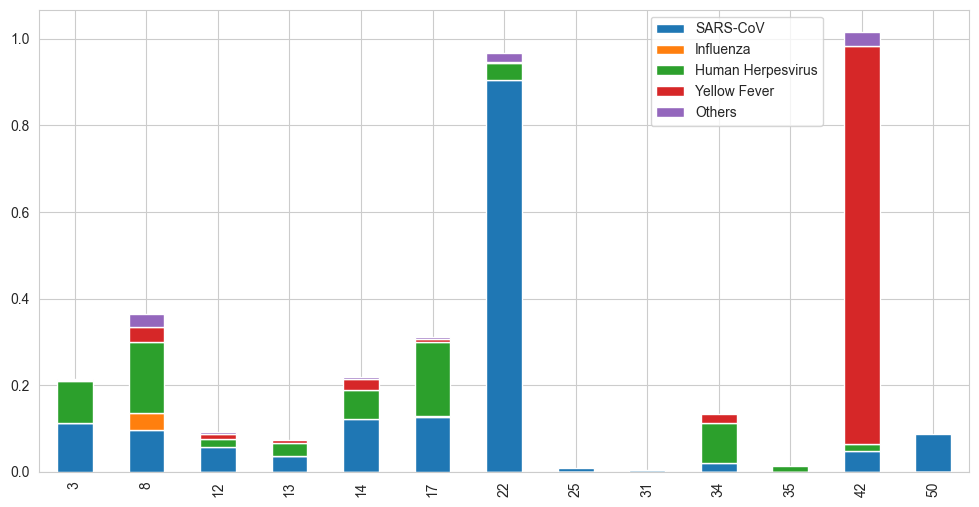

In [59]:
disease_norm, disease_count_ct = count_plots_disease(data.uns[f'moe_disease_by_leiden'], 'moe')

In [60]:
medium_cv = disease_norm[(disease_norm['SARS-CoV']>0.5)
            & (disease_count_ct['SARS-CoV']>0.05)].index
medium_cv

Index(['3', '12', '14', '22', '50'], dtype='object')

In [61]:
medium_bs = disease_norm[(disease_norm[['Influenza', 'Human Herpesvirus', 'Yellow Fever', 'Others']].sum(axis=1)>0.5)
            & (disease_count_ct[['Influenza', 'Human Herpesvirus', 'Yellow Fever', 'Others']].sum(axis=1)>0.05)].index
medium_bs

Index(['8', '17', '34', '42'], dtype='object')

In [62]:
filter_gene_prefixs = ['TRAV', 'TRAJ', 'TRAC', 'TRB', 'TRDV', 'TRDC', 'TRG']
non_tcr_genes = data.var_names

print(len(non_tcr_genes))
for prefix in filter_gene_prefixs:
    non_tcr_genes = [el for el in non_tcr_genes if not el.startswith(prefix)]
print(len(non_tcr_genes))

5000
4845


In [63]:
def get_significant_genes(bs_cluster, cv_clusters, vs_rest=False):
    def assign_cd8_status(c):
        if c in cv_clusters:
            return 'Covid'
        if c in bs_cluster:
            return 'Bystander'
        if vs_rest:
            return 'Rest'
        return np.nan
    data.obs['cd8te_assignment'] = data.obs['leiden_moe_cd8te'].apply(assign_cd8_status)
    data_test = data[~data.obs['cd8te_assignment'].isna()]
    data_test = data_test[:, non_tcr_genes].copy()

    sc.tl.rank_genes_groups(data_test, groupby='cd8te_assignment')
   
    idx_sig_by = data_test.uns['rank_genes_groups']['pvals_adj']['Bystander']<0.05  
    idx_by = np.logical_and(idx_sig_by, data_test.uns['rank_genes_groups']['logfoldchanges']['Bystander']>0.25)
    
    idx_sig_cv = data_test.uns['rank_genes_groups']['pvals_adj']['Covid']<0.05
    idx_cv = np.logical_and(idx_sig_cv, data_test.uns['rank_genes_groups']['logfoldchanges']['Covid']>0.25)
    
    genes_by = data_test.uns['rank_genes_groups']['names']['Bystander'][idx_by]
    genes_cv = data_test.uns['rank_genes_groups']['names']['Covid'][idx_cv]
    
    return genes_by.tolist(), genes_cv.tolist(), data_test

In [64]:
genes_by_mvtcr, genes_cv_mvtcr, data_selected = get_significant_genes(medium_cv, medium_bs)

In [65]:
genes = data_selected.uns['rank_genes_groups']['names']['Bystander'].tolist()

lfc_by = data_selected.uns['rank_genes_groups']['logfoldchanges']['Bystander'].tolist()
pval_by = data_selected.uns['rank_genes_groups']['pvals']['Bystander'].tolist()
pvalAd_by = data_selected.uns['rank_genes_groups']['pvals_adj']['Bystander'].tolist()


df_genes = pd.DataFrame(data={'Gene': genes, 
                              'logfoldchange': lfc_by, 
                              'pvalue': pval_by, 
                              'pvalueAdjusted': pvalAd_by,
                             })
df_genes.to_excel('../results/supplement/s5_haniffa_degs.xlsx', sheet_name='DEGs_mvTCR')
data.uns['rank_genes_groups_moe'] = data_selected.uns['rank_genes_groups']
data.obs['cd8te_assignment_moe'] = data_selected.obs['cd8te_assignment']

data.uns['cluster_covid_moe'] = medium_cv
data.uns['cluster_bystander_moe'] = medium_bs

data.uns['genes_covid_moe'] = genes_cv_mvtcr
data.uns['genes_bystander_moe'] = genes_by_mvtcr

### RNA selection

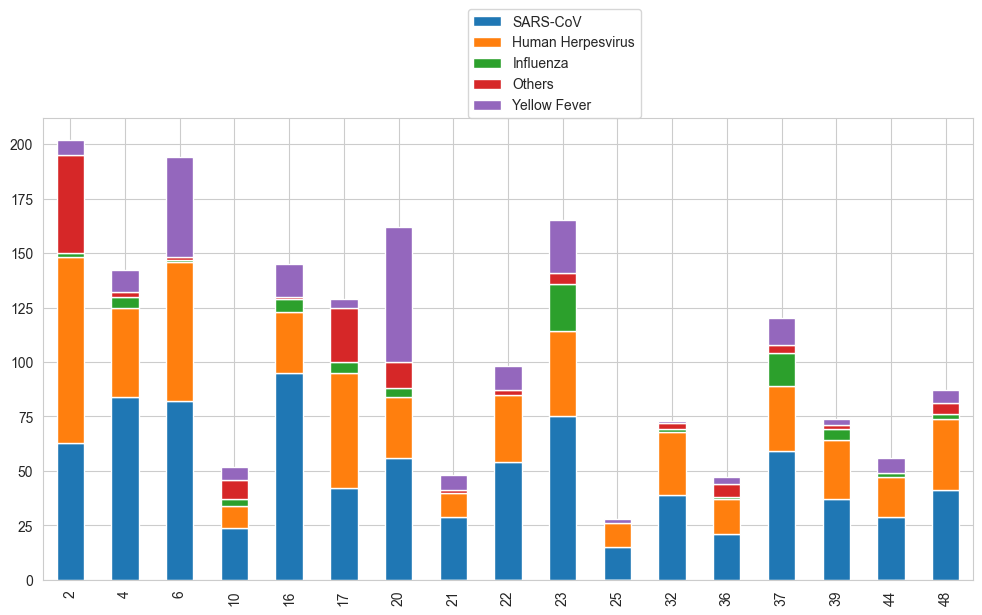

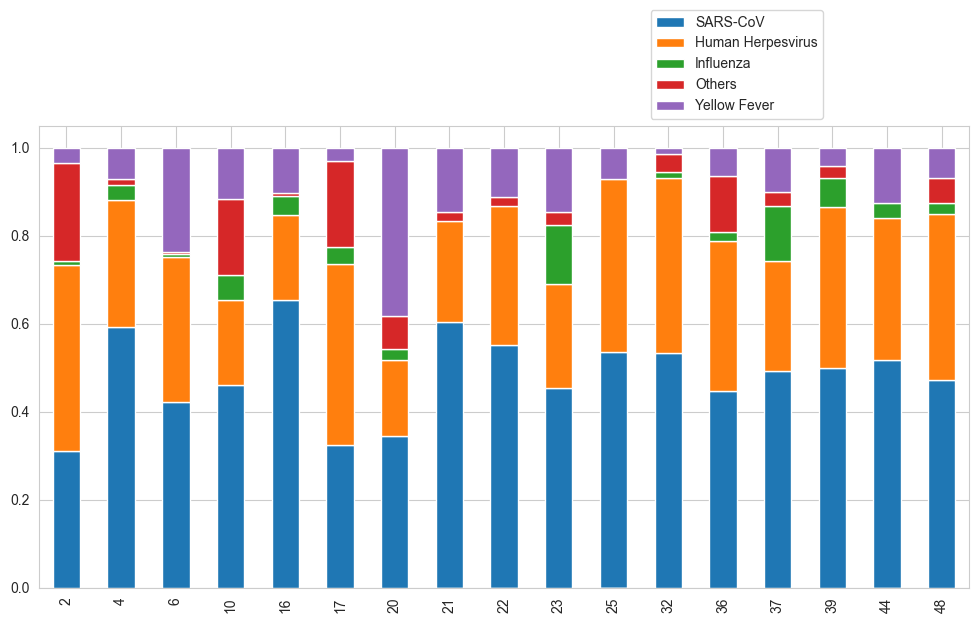

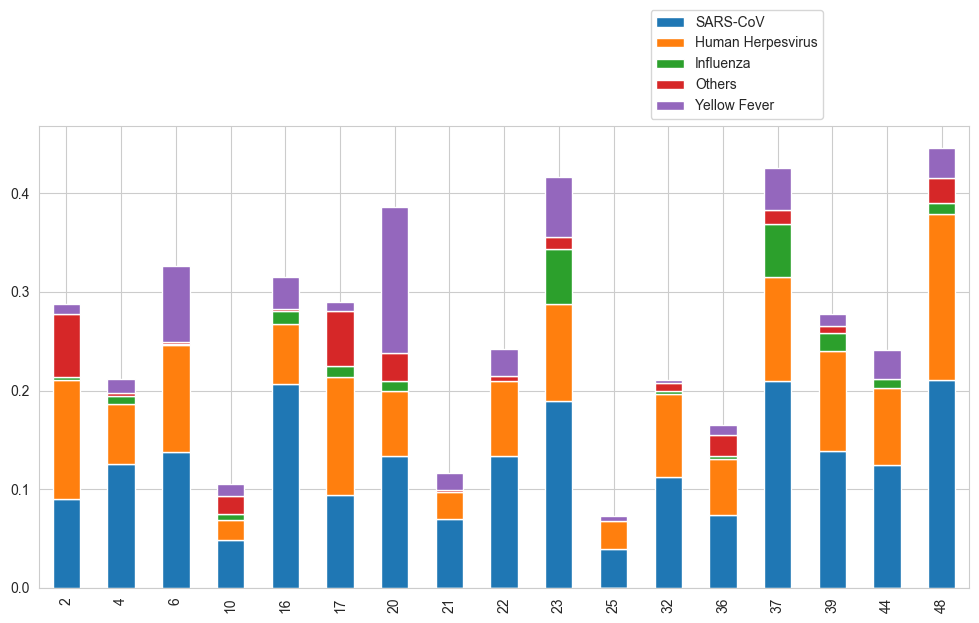

In [66]:
disease_norm, disease_count_ct = count_plots_disease(data.uns[f'rna_disease_by_leiden'], 'rna')

In [67]:
medium_cv = disease_norm[(disease_norm['SARS-CoV']>0.5)
            & (disease_count_ct['SARS-CoV']>0.05)].index
medium_cv

Index(['4', '16', '21', '22', '32', '44'], dtype='object')

In [68]:
medium_bs = disease_norm[(disease_norm[['Influenza', 'Human Herpesvirus', 'Yellow Fever', 'Others']].sum(axis=1)>0.5)
            & (disease_count_ct[['Influenza', 'Human Herpesvirus', 'Yellow Fever', 'Others']].sum(axis=1)>0.05)].index
medium_bs

Index(['2', '6', '10', '17', '20', '23', '36', '37', '48'], dtype='object')

In [69]:
genes_by_rna, genes_cv_rna, data_selected = get_significant_genes(medium_cv, medium_bs)

In [70]:
genes = data_selected.uns['rank_genes_groups']['names']['Bystander'].tolist()

lfc_by = data_selected.uns['rank_genes_groups']['logfoldchanges']['Bystander'].tolist()
pval_by = data_selected.uns['rank_genes_groups']['pvals']['Bystander'].tolist()
pvalAd_by = data_selected.uns['rank_genes_groups']['pvals_adj']['Bystander'].tolist()


df_genes = pd.DataFrame(data={'Gene': genes, 
                              'logfoldchange': lfc_by, 
                              'pvalue': pval_by, 
                              'pvalueAdjusted': pvalAd_by,
                             })

with pd.ExcelWriter('../results/supplement/s5_haniffa_degs.xlsx', mode='a') as writer: 
    df_genes.to_excel(writer, sheet_name='RNA')
    
data.uns['rank_genes_groups_rna'] = data_selected.uns['rank_genes_groups']
data.obs['cd8te_assignment_rna'] = data_selected.obs['cd8te_assignment']

data.uns['cluster_covid_rna'] = medium_cv
data.uns['cluster_bystander_rna'] = medium_bs

data.uns['genes_covid_rna'] = genes_cv_rna
data.uns['genes_bystander_rna'] = genes_by_rna

### TCR Analysis

In [71]:
data_selected = data[~data.obs['Specificity_IEDB'].isna()]
data_selected = data_selected[data_selected.obs['Specificity_IEDB']!='nan']
data_selected.obs['cd8te_assignment'] = data_selected.obs['Specificity_IEDB'].apply(lambda x: 'Covid' 
                                                                             if x == 'SARS-CoV' else 'Bystander')

data_selected = data_selected[:, non_tcr_genes].copy()
data.obs['TCR_groups'] = data_selected.obs['cd8te_assignment']
data_selected.obs['cd8te_assignment'].value_counts()

Covid        2994
Bystander    1585
Name: cd8te_assignment, dtype: int64

In [72]:
sc.tl.rank_genes_groups(data_selected, groupby='cd8te_assignment')
   
idx_sig_by = data_selected.uns['rank_genes_groups']['pvals_adj']['Bystander']<0.05  
idx_by = np.logical_and(idx_sig_by, data_selected.uns['rank_genes_groups']['logfoldchanges']['Bystander']>0.25)
    
idx_sig_cv = data_selected.uns['rank_genes_groups']['pvals_adj']['Covid']<0.05
idx_cv = np.logical_and(idx_sig_cv, data_selected.uns['rank_genes_groups']['logfoldchanges']['Covid']>0.25)
    
genes_by_tcr = data_selected.uns['rank_genes_groups']['names']['Bystander'][idx_by]
genes_cv_tcr = data_selected.uns['rank_genes_groups']['names']['Covid'][idx_cv]

In [73]:
genes = data_selected.uns['rank_genes_groups']['names']['Bystander'].tolist()

lfc_by = data_selected.uns['rank_genes_groups']['logfoldchanges']['Bystander'].tolist()
pval_by = data_selected.uns['rank_genes_groups']['pvals']['Bystander'].tolist()
pvalAd_by = data_selected.uns['rank_genes_groups']['pvals_adj']['Bystander'].tolist()


df_genes = pd.DataFrame(data={'Gene': genes, 
                              'logfoldchange': lfc_by, 
                              'pvalue': pval_by, 
                              'pvalueAdjusted': pvalAd_by,
                             })
with pd.ExcelWriter('../results/supplement/s5_haniffa_degs.xlsx', mode='a') as writer: 
    df_genes.to_excel(writer, sheet_name='TCR')
    
data.uns['rank_genes_groups_tcr'] = data_selected.uns['rank_genes_groups']
data.obs['cd8te_assignment_tcr'] = data_selected.obs['cd8te_assignment']

data.uns['genes_covid_tcr'] = genes_cv_tcr
data.uns['genes_bystander_tcr'] = genes_by_tcr

### Compare overlap

In [74]:
cols_overlap = ['mvTCR_covid', 'rna_covid', 'tcr_covid', 'mvTCR_bystander', 'rna_bystander', 'tcr_bystander']
genes = [genes_cv_mvtcr, genes_cv_rna, genes_cv_tcr, genes_by_mvtcr, genes_by_rna, genes_by_tcr]
df_overlap = pd.DataFrame(columns=cols_overlap, index=cols_overlap)

for col1, genes_1 in zip(cols_overlap, genes):
    for col2, genes_2 in zip(cols_overlap, genes):
        df_overlap.loc[col1, col2] = len(set(genes_1).intersection(genes_2))
for col in cols_overlap:
    df_overlap[col] = df_overlap[col].astype(int)
data.uns['deg_overlap'] = df_overlap

### Save results

In [75]:
for col in ['cluster_covid_rna', 'cluster_bystander_rna', 
            'cluster_covid_moe', 'cluster_bystander_moe',]:
    data.uns[col] = data.uns[col].tolist()

In [76]:
sc.write(adata=data, filename=path_out, compression='gzip')

In [77]:
data = sc.read(path_out)

# TcrDist3

In [78]:
from tcrdist.repertoire import TCRrep
from tcrdist.tree import TCRtree
from tqdm import tqdm

In [79]:
data_cd8te = data[data.obs['full_clustering']=='CD8.TE'].copy()

In [80]:
df_cd8ef = data_cd8te.obs.copy()
df_cd8ef = df_cd8ef[['v_gene_alpha', 'IR_VJ_1_junction_aa', 
                     'v_gene_beta', 'IR_VDJ_1_junction_aa', 'clonotype']]
df_cd8ef = df_cd8ef.drop_duplicates(['IR_VJ_1_junction_aa', 'IR_VDJ_1_junction_aa'])
df_cd8ef = df_cd8ef.reset_index(drop=True)
df_cd8ef = df_cd8ef.rename(columns={
    'v_gene_alpha': 'v_a_gene',
    'IR_VJ_1_junction_aa': 'cdr3_a_aa',
    
    'v_gene_beta': 'v_b_gene',
    'IR_VDJ_1_junction_aa':  'cdr3_b_aa'
})

for col in df_cd8ef.columns:
    dtype = str
    if col == 'clonotype':
        dtype = int
    df_cd8ef[col] = df_cd8ef[col].astype(dtype)
    
df_cd8ef['v_a_gene'] = df_cd8ef['v_a_gene'] + '*01'
df_cd8ef['v_b_gene'] = df_cd8ef['v_b_gene'] + '*01'
df_cd8ef.head(5)

v_a_gene         cdr3_a_aa    v_b_gene           cdr3_b_aa  clonotype
0     TRAV8-4*01   CAVSVVRNNNARLMF  TRBV5-1*01  CASSARGASGERTDTQYF          0
1  TRAV29/DV5*01  CAASARGGGSNYKLTF  TRBV3-1*01     CASRPGTGDTGELFF         34
2      TRAV19*01     CALNSNSGYALNF  TRBV6-6*01     CASKVGSGGGNTIYF         37
3    TRAV13-1*01        CAANDYKLSF  TRBV7-9*01     CASSPNSPGVNEQYF         84
4     TRAV1-2*01    CAVGSVGSARQLTF  TRBV7-2*01     CASSPRGQGGEPQHF         92

In [81]:
tr = TCRrep(cell_df=df_cd8ef, organism='human', chains=['alpha','beta'])
#dists = tr.pw_alpha + tr.pw_beta
dists = tr.pw_cdr3_a_aa + tr.pw_cdr3_b_aa
mask = np.triu(np.ones_like(dists), k=1)
dists = dists.max() - dists
dists = mask * dists + (1-mask) *(-99)

columns = tr.clone_df['clonotype']
dists_tcr = pd.DataFrame(dists, columns=columns, index=columns)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:31<00:00,  2.44s/it]


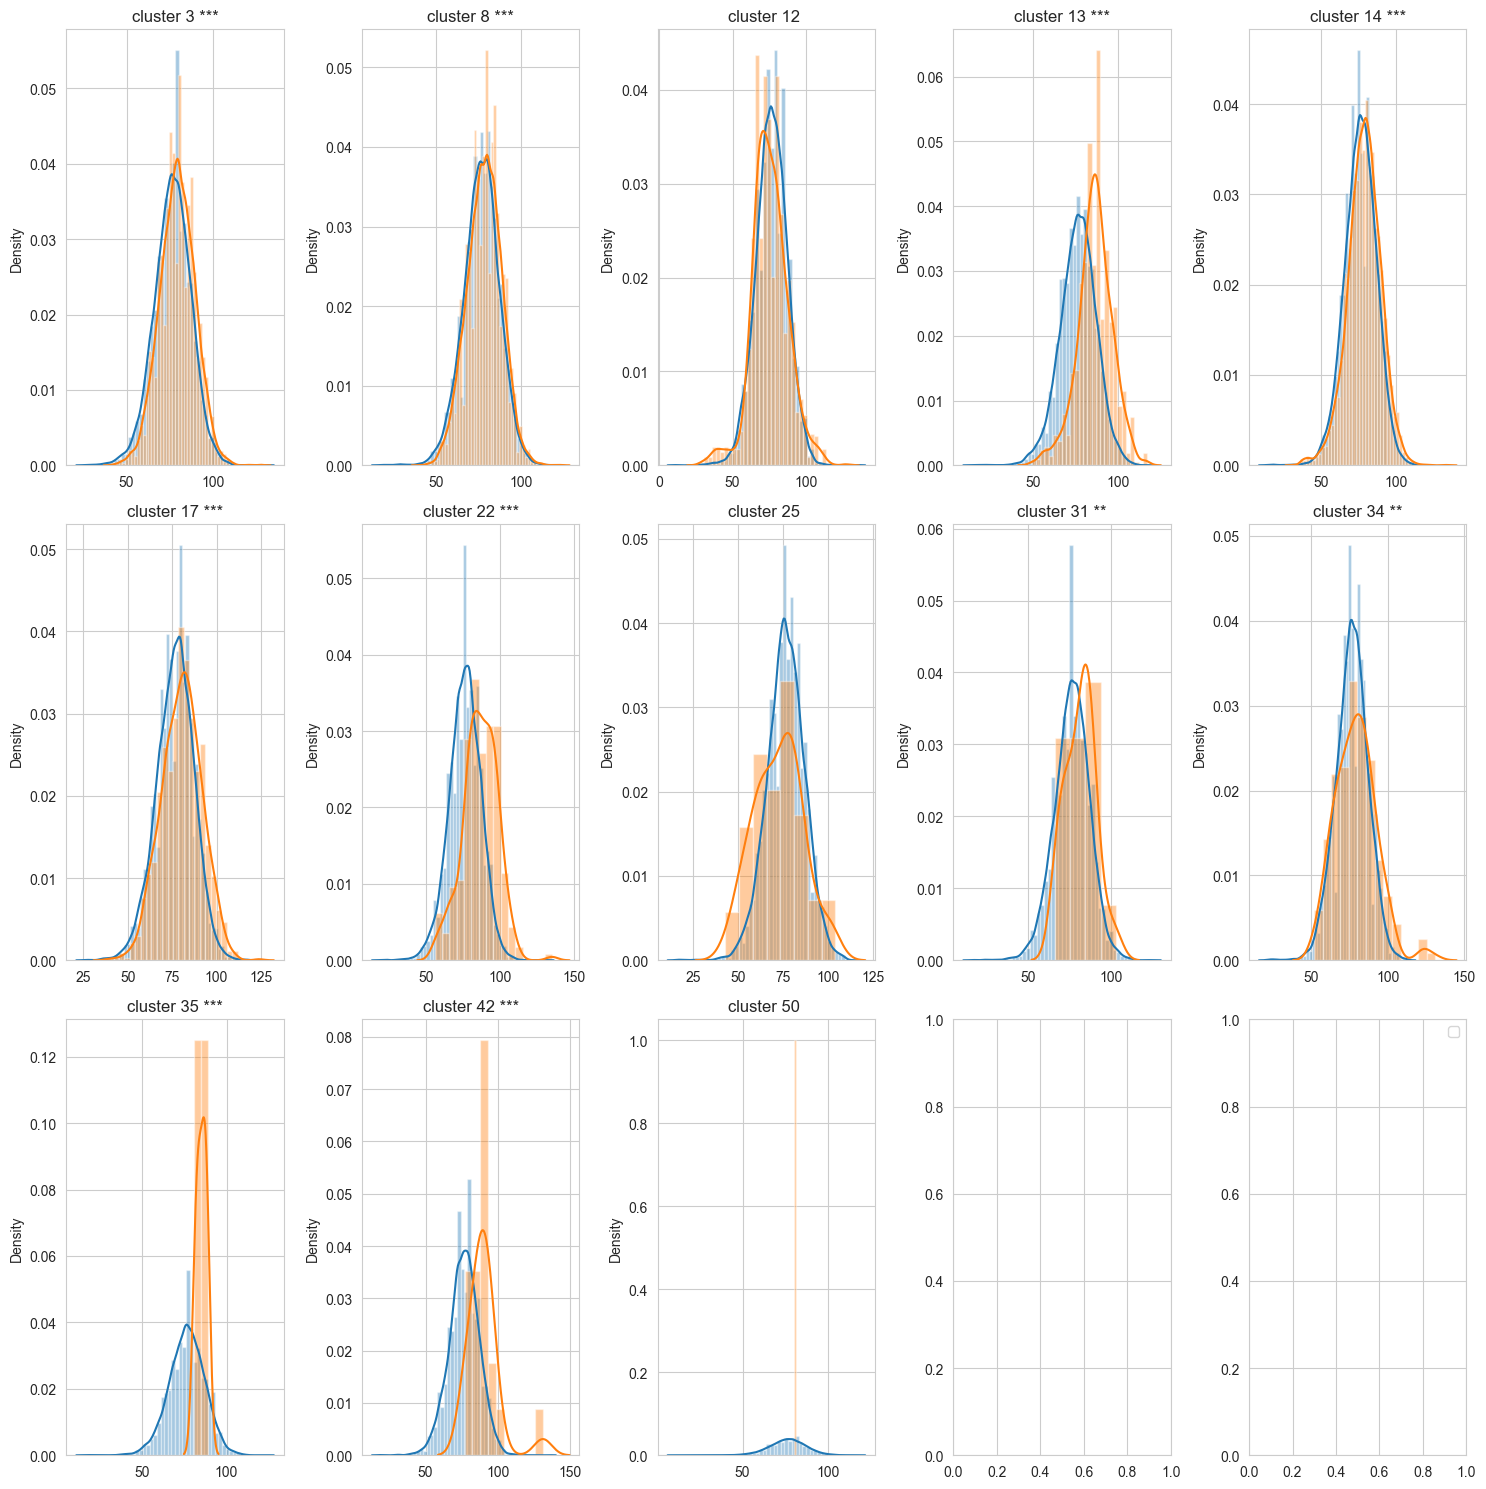

In [82]:
n_cols = 5
n_rows = 3
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols*3, n_cols*3))
axes = axes.reshape(-1)

p_values = {}
for i, cluster in enumerate(tqdm(data.uns['moe_reactiveClusters'])):
    cts = data_cd8te[data_cd8te.obs['leiden_moe_cd8te']==cluster].obs['clonotype'].unique()
    dist_cluster = dists_tcr[cts]
    dist_cluster = dist_cluster.loc[cts].values
    dist_cluster = dist_cluster[dist_cluster!=-99]
    
    background = dists_tcr.values
    background = background[background!=-99]
    
    p = scipy.stats.ttest_ind(a=dist_cluster, b=background, equal_var=False, alternative='greater')
    p_values[cluster] = p

    p = p[1]
    p_sign = map_pvalue_sign(p)
    
    
    background = np.random.choice(background, size=int(1e4), replace=False)
    sb.distplot(background, label='background', ax=axes[i])
    sb.distplot(dist_cluster, label=f'cluster', ax=axes[i])
    #axes[i].legend()
    axes[i].set_title(f'cluster {cluster} {p_sign}')
        
fig.tight_layout()
plt.legend()
plt.show()

In [83]:
tcr_dist_sig = [el for el, p in p_values.items() if p[1]<0.001]
len(tcr_dist_sig)

8

In [84]:
clusters = []
t_stats = []
p_vals = []

for c, summary in p_values.items():
    clusters.append(c)
    t_stats.append(summary[0])
    p_vals.append(summary[1])

df_s2_tcrdist = pd.DataFrame(data={'clusters': clusters, 't-statistic': t_stats, 'p-value': p_vals})
with pd.ExcelWriter('../results/supplement/s2_statistics_sars_cov_clusters.xlsx', mode='a') as writer:  
    df_s2_tcrdist.to_excel(writer, sheet_name='TCR_similarity')
df_s2_tcrdist

clusters  t-statistic        p-value
0         3    24.135995  3.517739e-124
1         8    20.313371   1.250970e-90
2        12    -3.119015   9.990732e-01
3        13    27.557363  1.262252e-120
4        14    21.084555   8.870193e-97
5        17    11.414572   6.169369e-29
6        22    13.210834   2.507215e-30
7        25    -2.807372   9.969383e-01
8        31     2.942987   3.302206e-03
9        34     2.889722   2.131218e-03
10       35     7.131236   4.207342e-04
11       42     5.510396   1.075670e-05
12       50          NaN            NaN

## Gene distance

In [85]:
from scipy import stats
from tqdm import tqdm

In [86]:
rs_squared_rna = np.corrcoef(data_cd8te.obsm['X_pca']) #X.A)

In [87]:
rs_squared_rna = np.triu(rs_squared_rna, k=1)
rs_squared_rna[rs_squared_rna==0] = -99 
np.fill_diagonal(rs_squared_rna, 0) # set self distance back to zero

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:00<00:00,  4.66s/it]


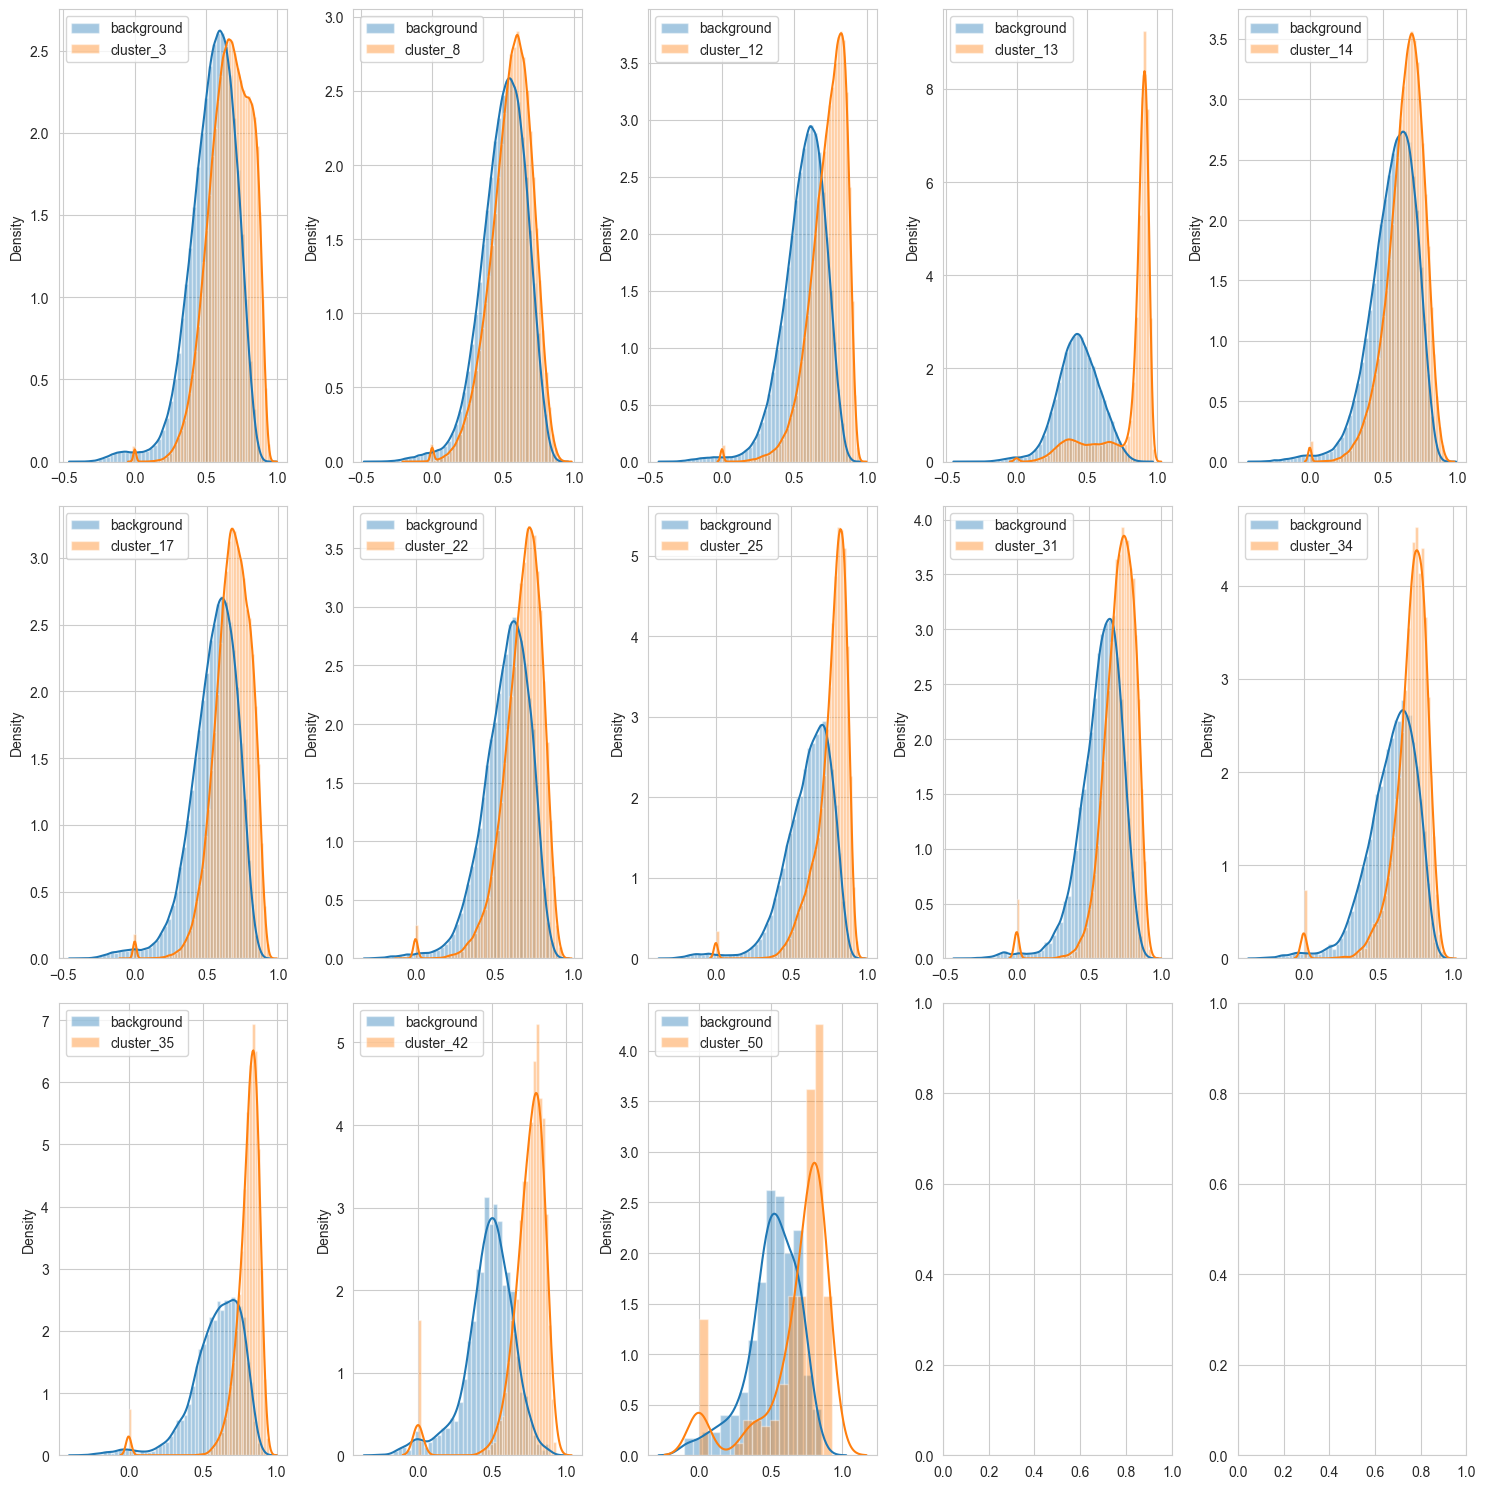

In [88]:
n_cols = 5
n_rows = 3
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols*3, n_cols*3))
axes = axes.reshape(-1)


for i, cluster in enumerate(tqdm(data.uns['moe_reactiveClusters'])):
    mask_cluster = (data_cd8te.obs['leiden_moe_cd8te'] == cluster).values
    corr_cluster = rs_squared_rna[mask_cluster][:, mask_cluster]
    corr_cluster = corr_cluster[corr_cluster!=-99]

    background = rs_squared_rna[mask_cluster][:, np.invert(mask_cluster)]
    background = background[background!=-99]

    background = np.random.choice(background, size=corr_cluster.shape[0], replace=False)
    sb.distplot(background, label='background', ax=axes[i])
    sb.distplot(corr_cluster, label=f'cluster_{cluster}', ax=axes[i])
    axes[i].legend()

fig.tight_layout()
plt.show()

In [89]:
p_values = {}
for cluster in data.uns['moe_reactiveClusters']:
    mask_cluster = (data_cd8te.obs['leiden_moe_cd8te'] == cluster).values
    corr_cluster = rs_squared_rna[mask_cluster][:, mask_cluster]
    corr_cluster = corr_cluster[corr_cluster!=-99]

    background = rs_squared_rna[mask_cluster][:, np.invert(mask_cluster)]
    background = background[background!=-99]

    p = scipy.stats.ttest_ind(a=corr_cluster, b=background, equal_var=False, alternative='greater')
    p_values[cluster] = p
    
rs_squared_rna = pd.DataFrame(rs_squared_rna, index=data_cd8te.obs.index, columns=data_cd8te.obs.index)
p_values

{'3': Ttest_indResult(statistic=633.2856007798772, pvalue=0.0),
 '8': Ttest_indResult(statistic=202.79735090690633, pvalue=0.0),
 '12': Ttest_indResult(statistic=640.0520606163102, pvalue=0.0),
 '13': Ttest_indResult(statistic=901.7290838185253, pvalue=0.0),
 '14': Ttest_indResult(statistic=284.9221834529979, pvalue=0.0),
 '17': Ttest_indResult(statistic=380.97838238617703, pvalue=0.0),
 '22': Ttest_indResult(statistic=195.65752368216533, pvalue=0.0),
 '25': Ttest_indResult(statistic=281.7957442783136, pvalue=0.0),
 '31': Ttest_indResult(statistic=143.11163451661034, pvalue=0.0),
 '34': Ttest_indResult(statistic=93.38687954688119, pvalue=0.0),
 '35': Ttest_indResult(statistic=172.1300455931899, pvalue=0.0),
 '42': Ttest_indResult(statistic=69.30963158900995, pvalue=0.0),
 '50': Ttest_indResult(statistic=10.939716565023767, pvalue=1.0577907843022384e-23)}

In [90]:
clusters = []
t_stats = []
p_vals = []

for c, summary in p_values.items():
    clusters.append(c)
    t_stats.append(summary[0])
    p_vals.append(summary[1])

df_s2_tcrdist = pd.DataFrame(data={'clusters': clusters, 't-statistic': t_stats, 'p-value': p_vals})
with pd.ExcelWriter('../results/supplement/s2_statistics_sars_cov_clusters.xlsx', mode='a') as writer:  
    df_s2_tcrdist.to_excel(writer, sheet_name='GEX_similarity')
df_s2_tcrdist

clusters  t-statistic       p-value
0         3   633.285601  0.000000e+00
1         8   202.797351  0.000000e+00
2        12   640.052061  0.000000e+00
3        13   901.729084  0.000000e+00
4        14   284.922183  0.000000e+00
5        17   380.978382  0.000000e+00
6        22   195.657524  0.000000e+00
7        25   281.795744  0.000000e+00
8        31   143.111635  0.000000e+00
9        34    93.386880  0.000000e+00
10       35   172.130046  0.000000e+00
11       42    69.309632  0.000000e+00
12       50    10.939717  1.057791e-23

## Cluster comparisson

In [91]:
tr = TCRrep(cell_df=df_cd8ef, organism='human', chains=['alpha','beta'])
dists = tr.pw_cdr3_a_aa + tr.pw_cdr3_b_aa
mask = np.triu(np.ones_like(dists))
dists = dists.max() - dists
dists = mask * dists + (1-mask) *(-99)

columns = tr.clone_df['clonotype']
dists_tcr = pd.DataFrame(dists, columns=columns, index=columns)

metric           model
Days-std         full       6.552486
                 moe        2.932960
                 rna        3.884688
                 tcr        7.612267
RNA-correlation  full       0.547025
                 moe        0.705674
                 rna        0.663297
                 tcr        0.536165
Status-purity    full       0.433117
                 moe        0.765662
                 rna        0.717502
                 tcr        0.411571
TCR-Similarity   full      76.210404
                 moe      116.381675
                 rna       85.872955
                 tcr       84.783377
Name: score, dtype: float64

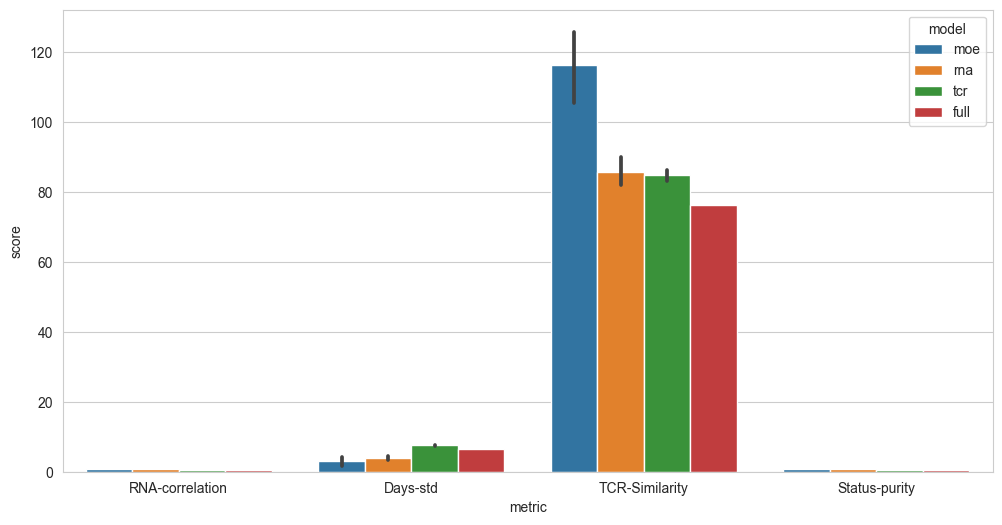

In [92]:
data_cd8te = data[data.obs['full_clustering']=='CD8.TE'].copy()
data_cd8te.obs['full'] ='yes'

models = []
clusters = []
metrics = []
scores = []


for model, cols in [('moe', 'leiden_moe_cd8te'), ('rna', 'leiden_rna_cd8te'), ('tcr', 'TCR_groups'), ('full', 'full')]:
    data_tmp = data_cd8te
    if model in ['moe', 'rna']:
        data_tmp = data_tmp[data_tmp.obs[f'leiden_{model}_cd8te'].isin(data.uns[f'{model}_reactiveClusters'])]
    elif model == 'tcr':
        data_tmp = data_tmp[~data_tmp.obs['TCR_groups'].isna()]
    for cluster in data_tmp.obs[cols].unique():
        data_cluster = data_tmp[data_tmp.obs[cols]==cluster]
        barcodes = data_cluster.obs.index
        
        models.append(model)
        clusters.append(cluster)
        metrics.append('RNA-correlation')
        score = rs_squared_rna.loc[barcodes, barcodes].values.flatten()
        score = score[score!=-99].mean()
        scores.append(score)
        
        models.append(model)
        clusters.append(cluster)
        metrics.append('Days-std')
        score = data_cluster.obs[['Days_from_onset']]
        score = score[~score['Days_from_onset'].isin(['Healthy', 'Non_covid', 'LPS', 'nan'])].astype(str).astype(int)
        score = score['Days_from_onset'].std()
        scores.append(score)
        
        models.append(model)
        clusters.append(cluster)
        metrics.append('TCR-Similarity')
        clonotypes = data_cluster.obs['clonotype']
        score = dists_tcr.loc[clonotypes, clonotypes].values.flatten()
        score = score[score!=-99].mean()
        scores.append(score)
        
        models.append(model)
        clusters.append(cluster)
        metrics.append('Status-purity')
        score = data_cluster.obs['Status_on_day_collection'].value_counts(normalize=True)[0]
        scores.append(score)
    
cluster_coherence = pd.DataFrame({'model': models, 'cluster': clusters, 'metric': metrics, 'score': scores})
sb.barplot(data=cluster_coherence, x='metric', hue='model', y='score')
cluster_coherence.groupby(['metric', 'model'])['score'].mean()

In [93]:
with pd.ExcelWriter('../results/supplement/s2_statistics_sars_cov_clusters.xlsx', mode='a') as writer:  
    cluster_coherence.to_excel(writer, sheet_name='Cluster_comparision')

In [94]:
from sklearn.metrics import normalized_mutual_info_score
for model in ['moe', 'rna', 'tcr']:
    data_tmp = data_cd8te
    if model in ['moe', 'rna']:
        data_tmp = data_tmp[data_tmp.obs[f'leiden_{model}_cd8te'].isin(data.uns[f'{model}_reactiveClusters'])]
        col = f'leiden_{model}_cd8te' 
    elif model == 'tcr':
        data_tmp = data_tmp[~data_tmp.obs['TCR_groups'].isna()]
        col = 'TCR_groups'
        
    nmi = normalized_mutual_info_score(data_tmp.obs['Status_on_day_collection'].values, data_tmp.obs[col].values)
    print(f'NMI Status - {model}-clusters: {nmi}')

NMI Status - moe-clusters: 0.2653450950826622
NMI Status - rna-clusters: 0.15062148086732255
NMI Status - tcr-clusters: 0.03059256186984095


In [95]:
data.uns['cluster_comparisson'] = cluster_coherence
sc.write(adata=data, filename=path_out, compression='gzip')
data = sc.read(path_out)